In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
def get_titeseq_replicate_df(replicate_number='1'):

    data_df_full = pd.read_csv(f'data/replicate_{replicate_number}.csv',index_col=[0])
    y_cols = list(data_df_full.columns[14:58])
    cols = y_cols.copy()
    # Currently concatenating CDR1-H and CDR3-H sequencnes. Not sure if correct.
    data_df_full['x'] = (data_df_full['CDR1H_AA']+data_df_full['CDR3H_AA']).values
    cols.insert(0,'x')
    data_df = data_df_full[cols].copy()
    
    return data_df
    

In [3]:
replicate_1_df = get_titeseq_replicate_df('1')
replicate_2_df = get_titeseq_replicate_df('2')
replicate_3_df = get_titeseq_replicate_df('3')

data_df = replicate_1_df.append(replicate_2_df, ignore_index=True).append(replicate_3_df, ignore_index=True).reset_index(drop=True).copy()


In [4]:
data_df.shape

(11039, 45)

In [5]:
data_df_full_rep_1 = pd.read_csv(f'data/replicate_1.csv',index_col=[0])
y_cols = list(data_df_full_rep_1.columns[14:58])
X = data_df['x']
y = data_df[y_cols]

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y',]


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=20, Y=44


In [7]:
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-08-07 09:26:02.390706: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [9]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [10]:
print(N_y)

fluorescein0bin0          15885950
fluorescein0bin1            845949
fluorescein0bin2          14646947
fluorescein0bin3            480168
fluorescein10^-5.5bin0     4938811
fluorescein10^-5.5bin1     3558812
fluorescein10^-5.5bin2     7335952
fluorescein10^-5.5bin3     7306329
fluorescein10^-5bin0      12323072
fluorescein10^-5bin1       1386792
fluorescein10^-5bin2      14067051
fluorescein10^-5bin3      14797633
fluorescein10^-6.5bin0     7778006
fluorescein10^-6.5bin1     1084990
fluorescein10^-6.5bin2     6335215
fluorescein10^-6.5bin3    14460000
fluorescein10^-6bin0       1870048
fluorescein10^-6bin1       6027256
fluorescein10^-6bin2       2933272
fluorescein10^-6bin3      10097157
fluorescein10^-7.5bin0     3535644
fluorescein10^-7.5bin1     1078611
fluorescein10^-7.5bin2     3070755
fluorescein10^-7.5bin3     3000078
fluorescein10^-7bin0       3645702
fluorescein10^-7bin1        565856
fluorescein10^-7bin2       8837515
fluorescein10^-7bin3       2756860
fluorescein10^-8.5bi

#### I approximated these values from Fig 2B

In [11]:
bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,0,180
1,180,1400
2,1400,10500
3,10500,250000


### I don't know how to obtain these values
Using arbitrary values for now just to be able to debug Titeseq MP.
Get these from figure 2B

In [12]:
mu_neg = 50
mu_pos = 700000
sigma_neg = 100
sigma_pos = 50000

In [13]:
mp_list = [mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=10,
                                                                      eta=1e-5,)
           for mp in range(len(y_cols)//4)
          ]

In [14]:
# there are 16 measurement processes in this 
len(mp_list)

11

In [15]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=mp_list)

In [16]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 444)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 400)          0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           401         ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [17]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,                                                        
                      ],

               shuffle=False)

N = 10,487 observations set as training data.
Using 20.1% for validation.
Time to set data: 0.661 sec.


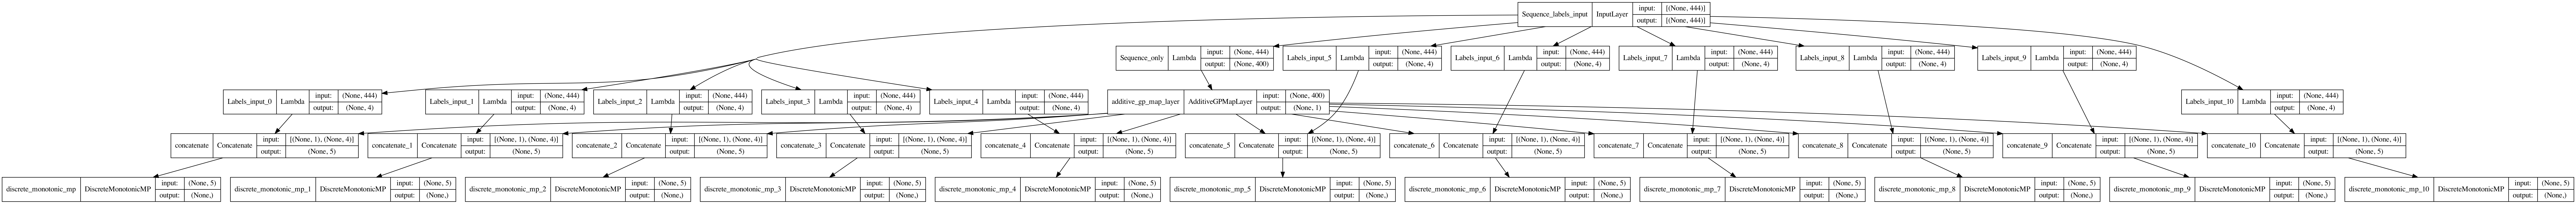

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=300,to_file='pngs/DiscreteMonotonic_MP/titeseq16_dar.png')

In [19]:

# Fit model to data
model.fit(learning_rate=.0001,
          epochs=750,
          batch_size=250,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=50,
          linear_initialization=False)

Epoch 1/750
34/34 [==============================] - 11s 79ms/step - loss: 7183760.0000 - discrete_monotonic_mp_loss: 625984.7500 - discrete_monotonic_mp_1_loss: 627704.1250 - discrete_monotonic_mp_2_loss: 1426904.3750 - discrete_monotonic_mp_3_loss: 700240.6875 - discrete_monotonic_mp_4_loss: 529173.1250 - discrete_monotonic_mp_5_loss: 273006.7500 - discrete_monotonic_mp_6_loss: 393730.9688 - discrete_monotonic_mp_7_loss: 699457.1250 - discrete_monotonic_mp_8_loss: 474125.4688 - discrete_monotonic_mp_9_loss: 792929.6875 - discrete_monotonic_mp_10_loss: 640503.0000 - I_var: -0.4067 - val_loss: 29565726.0000 - val_discrete_monotonic_mp_loss: 1982034.0000 - val_discrete_monotonic_mp_1_loss: 2342274.0000 - val_discrete_monotonic_mp_2_loss: 5486983.5000 - val_discrete_monotonic_mp_3_loss: 3406785.0000 - val_discrete_monotonic_mp_4_loss: 2295735.2500 - val_discrete_monotonic_mp_5_loss: 805505.1875 - val_discrete_monotonic_mp_6_loss: 1249882.5000 - val_discrete_monotonic_mp_7_loss: 4249115.0

Epoch 8/750
34/34 [==============================] - 0s 12ms/step - loss: 6402936.0000 - discrete_monotonic_mp_loss: 614239.5000 - discrete_monotonic_mp_1_loss: 522950.4062 - discrete_monotonic_mp_2_loss: 1117531.1250 - discrete_monotonic_mp_3_loss: 621402.1875 - discrete_monotonic_mp_4_loss: 461907.6562 - discrete_monotonic_mp_5_loss: 263611.1875 - discrete_monotonic_mp_6_loss: 354349.6875 - discrete_monotonic_mp_7_loss: 676947.6875 - discrete_monotonic_mp_8_loss: 455265.6875 - discrete_monotonic_mp_9_loss: 725679.9375 - discrete_monotonic_mp_10_loss: 589050.6250 - I_var: -0.2244 - val_loss: 23746192.0000 - val_discrete_monotonic_mp_loss: 1946880.0000 - val_discrete_monotonic_mp_1_loss: 1820594.7500 - val_discrete_monotonic_mp_2_loss: 3822916.5000 - val_discrete_monotonic_mp_3_loss: 2645335.7500 - val_discrete_monotonic_mp_4_loss: 1750821.2500 - val_discrete_monotonic_mp_5_loss: 691710.0625 - val_discrete_monotonic_mp_6_loss: 1076575.2500 - val_discrete_monotonic_mp_7_loss: 3548105.75

Epoch 15/750
34/34 [==============================] - 0s 10ms/step - loss: 6144257.0000 - discrete_monotonic_mp_loss: 623822.6875 - discrete_monotonic_mp_1_loss: 490076.9375 - discrete_monotonic_mp_2_loss: 1002572.9375 - discrete_monotonic_mp_3_loss: 594684.8750 - discrete_monotonic_mp_4_loss: 439532.0625 - discrete_monotonic_mp_5_loss: 262471.3125 - discrete_monotonic_mp_6_loss: 339440.3750 - discrete_monotonic_mp_7_loss: 671445.8125 - discrete_monotonic_mp_8_loss: 450594.2500 - discrete_monotonic_mp_9_loss: 695294.9375 - discrete_monotonic_mp_10_loss: 574320.0000 - I_var: -0.1771 - val_loss: 21563352.0000 - val_discrete_monotonic_mp_loss: 1993496.0000 - val_discrete_monotonic_mp_1_loss: 1649558.8750 - val_discrete_monotonic_mp_2_loss: 3158045.5000 - val_discrete_monotonic_mp_3_loss: 2347071.2500 - val_discrete_monotonic_mp_4_loss: 1529134.7500 - val_discrete_monotonic_mp_5_loss: 650272.8125 - val_discrete_monotonic_mp_6_loss: 1010446.1875 - val_discrete_monotonic_mp_7_loss: 3275609.7

Epoch 22/750
34/34 [==============================] - 0s 9ms/step - loss: 6048848.5000 - discrete_monotonic_mp_loss: 622676.2500 - discrete_monotonic_mp_1_loss: 479793.9688 - discrete_monotonic_mp_2_loss: 964006.6875 - discrete_monotonic_mp_3_loss: 584111.7500 - discrete_monotonic_mp_4_loss: 431681.6562 - discrete_monotonic_mp_5_loss: 260485.6250 - discrete_monotonic_mp_6_loss: 332800.8438 - discrete_monotonic_mp_7_loss: 665592.2500 - discrete_monotonic_mp_8_loss: 448558.8125 - discrete_monotonic_mp_9_loss: 688468.9375 - discrete_monotonic_mp_10_loss: 570671.6875 - I_var: -0.1581 - val_loss: 20923332.0000 - val_discrete_monotonic_mp_loss: 2002119.1250 - val_discrete_monotonic_mp_1_loss: 1606006.2500 - val_discrete_monotonic_mp_2_loss: 2974887.7500 - val_discrete_monotonic_mp_3_loss: 2251254.5000 - val_discrete_monotonic_mp_4_loss: 1458161.0000 - val_discrete_monotonic_mp_5_loss: 637999.5000 - val_discrete_monotonic_mp_6_loss: 987876.8125 - val_discrete_monotonic_mp_7_loss: 3204583.5000

Epoch 29/750
34/34 [==============================] - 0s 10ms/step - loss: 5965715.5000 - discrete_monotonic_mp_loss: 613199.2500 - discrete_monotonic_mp_1_loss: 473596.9062 - discrete_monotonic_mp_2_loss: 940965.8750 - discrete_monotonic_mp_3_loss: 575419.3750 - discrete_monotonic_mp_4_loss: 426462.5938 - discrete_monotonic_mp_5_loss: 258070.6406 - discrete_monotonic_mp_6_loss: 328434.7188 - discrete_monotonic_mp_7_loss: 655591.8750 - discrete_monotonic_mp_8_loss: 445498.6250 - discrete_monotonic_mp_9_loss: 682472.5625 - discrete_monotonic_mp_10_loss: 566002.8125 - I_var: -0.1444 - val_loss: 20669006.0000 - val_discrete_monotonic_mp_loss: 1980551.8750 - val_discrete_monotonic_mp_1_loss: 1593487.1250 - val_discrete_monotonic_mp_2_loss: 2908595.5000 - val_discrete_monotonic_mp_3_loss: 2210760.5000 - val_discrete_monotonic_mp_4_loss: 1431002.1250 - val_discrete_monotonic_mp_5_loss: 633551.9375 - val_discrete_monotonic_mp_6_loss: 976866.8125 - val_discrete_monotonic_mp_7_loss: 3185525.750

Epoch 36/750
34/34 [==============================] - 0s 9ms/step - loss: 5902625.5000 - discrete_monotonic_mp_loss: 603896.7500 - discrete_monotonic_mp_1_loss: 470535.6562 - discrete_monotonic_mp_2_loss: 924460.5000 - discrete_monotonic_mp_3_loss: 570775.8750 - discrete_monotonic_mp_4_loss: 423641.1562 - discrete_monotonic_mp_5_loss: 255925.5469 - discrete_monotonic_mp_6_loss: 324363.8125 - discrete_monotonic_mp_7_loss: 646517.4375 - discrete_monotonic_mp_8_loss: 443792.6562 - discrete_monotonic_mp_9_loss: 675758.9375 - discrete_monotonic_mp_10_loss: 562956.6250 - I_var: -0.1332 - val_loss: 20495780.0000 - val_discrete_monotonic_mp_loss: 1951262.0000 - val_discrete_monotonic_mp_1_loss: 1587889.7500 - val_discrete_monotonic_mp_2_loss: 2867296.5000 - val_discrete_monotonic_mp_3_loss: 2182567.5000 - val_discrete_monotonic_mp_4_loss: 1414137.1250 - val_discrete_monotonic_mp_5_loss: 631387.1250 - val_discrete_monotonic_mp_6_loss: 968303.9375 - val_discrete_monotonic_mp_7_loss: 3175319.2500

Epoch 43/750
34/34 [==============================] - 0s 10ms/step - loss: 5838020.0000 - discrete_monotonic_mp_loss: 591859.5000 - discrete_monotonic_mp_1_loss: 467205.6875 - discrete_monotonic_mp_2_loss: 908318.3750 - discrete_monotonic_mp_3_loss: 565641.2500 - discrete_monotonic_mp_4_loss: 420480.2812 - discrete_monotonic_mp_5_loss: 253868.9531 - discrete_monotonic_mp_6_loss: 320799.0312 - discrete_monotonic_mp_7_loss: 636567.6250 - discrete_monotonic_mp_8_loss: 441597.0000 - discrete_monotonic_mp_9_loss: 671446.3750 - discrete_monotonic_mp_10_loss: 560236.0625 - I_var: -0.1260 - val_loss: 20386232.0000 - val_discrete_monotonic_mp_loss: 1914243.5000 - val_discrete_monotonic_mp_1_loss: 1587047.3750 - val_discrete_monotonic_mp_2_loss: 2844845.5000 - val_discrete_monotonic_mp_3_loss: 2164773.5000 - val_discrete_monotonic_mp_4_loss: 1405450.3750 - val_discrete_monotonic_mp_5_loss: 630479.3750 - val_discrete_monotonic_mp_6_loss: 962098.0625 - val_discrete_monotonic_mp_7_loss: 3174794.250

Epoch 50/750
34/34 [==============================] - 0s 9ms/step - loss: 5778403.5000 - discrete_monotonic_mp_loss: 581446.8125 - discrete_monotonic_mp_1_loss: 464026.3125 - discrete_monotonic_mp_2_loss: 894514.3125 - discrete_monotonic_mp_3_loss: 559931.5625 - discrete_monotonic_mp_4_loss: 417475.4375 - discrete_monotonic_mp_5_loss: 252114.1406 - discrete_monotonic_mp_6_loss: 316765.8750 - discrete_monotonic_mp_7_loss: 627415.3750 - discrete_monotonic_mp_8_loss: 439865.2188 - discrete_monotonic_mp_9_loss: 665835.3125 - discrete_monotonic_mp_10_loss: 559013.5625 - I_var: -0.1193 - val_loss: 20257816.0000 - val_discrete_monotonic_mp_loss: 1880734.3750 - val_discrete_monotonic_mp_1_loss: 1585470.8750 - val_discrete_monotonic_mp_2_loss: 2819017.2500 - val_discrete_monotonic_mp_3_loss: 2144321.5000 - val_discrete_monotonic_mp_4_loss: 1394681.5000 - val_discrete_monotonic_mp_5_loss: 629468.4375 - val_discrete_monotonic_mp_6_loss: 955236.7500 - val_discrete_monotonic_mp_7_loss: 3168863.2500

Epoch 57/750
34/34 [==============================] - 0s 11ms/step - loss: 5726801.0000 - discrete_monotonic_mp_loss: 570293.0000 - discrete_monotonic_mp_1_loss: 461928.6875 - discrete_monotonic_mp_2_loss: 881256.3750 - discrete_monotonic_mp_3_loss: 555999.8750 - discrete_monotonic_mp_4_loss: 414807.0625 - discrete_monotonic_mp_5_loss: 250713.0312 - discrete_monotonic_mp_6_loss: 313388.2188 - discrete_monotonic_mp_7_loss: 619961.0000 - discrete_monotonic_mp_8_loss: 437771.5938 - discrete_monotonic_mp_9_loss: 663012.3125 - discrete_monotonic_mp_10_loss: 557670.5625 - I_var: -0.1152 - val_loss: 20120906.0000 - val_discrete_monotonic_mp_loss: 1850292.7500 - val_discrete_monotonic_mp_1_loss: 1583640.2500 - val_discrete_monotonic_mp_2_loss: 2792750.0000 - val_discrete_monotonic_mp_3_loss: 2122978.2500 - val_discrete_monotonic_mp_4_loss: 1382890.5000 - val_discrete_monotonic_mp_5_loss: 628417.1875 - val_discrete_monotonic_mp_6_loss: 947930.1250 - val_discrete_monotonic_mp_7_loss: 3159444.250

Epoch 64/750
34/34 [==============================] - 0s 10ms/step - loss: 5687274.5000 - discrete_monotonic_mp_loss: 561807.3750 - discrete_monotonic_mp_1_loss: 460631.7188 - discrete_monotonic_mp_2_loss: 871691.0625 - discrete_monotonic_mp_3_loss: 552260.6250 - discrete_monotonic_mp_4_loss: 413006.1875 - discrete_monotonic_mp_5_loss: 249908.0156 - discrete_monotonic_mp_6_loss: 310369.2812 - discrete_monotonic_mp_7_loss: 614218.6875 - discrete_monotonic_mp_8_loss: 436910.5625 - discrete_monotonic_mp_9_loss: 658641.9375 - discrete_monotonic_mp_10_loss: 557828.4375 - I_var: -0.1110 - val_loss: 20007990.0000 - val_discrete_monotonic_mp_loss: 1819576.0000 - val_discrete_monotonic_mp_1_loss: 1583350.0000 - val_discrete_monotonic_mp_2_loss: 2773563.2500 - val_discrete_monotonic_mp_3_loss: 2104853.5000 - val_discrete_monotonic_mp_4_loss: 1373283.7500 - val_discrete_monotonic_mp_5_loss: 628038.3125 - val_discrete_monotonic_mp_6_loss: 941455.8125 - val_discrete_monotonic_mp_7_loss: 3155000.000

Epoch 71/750
34/34 [==============================] - 0s 10ms/step - loss: 5632252.0000 - discrete_monotonic_mp_loss: 552705.3750 - discrete_monotonic_mp_1_loss: 458254.5000 - discrete_monotonic_mp_2_loss: 861134.7500 - discrete_monotonic_mp_3_loss: 547286.7500 - discrete_monotonic_mp_4_loss: 410035.7188 - discrete_monotonic_mp_5_loss: 248852.5469 - discrete_monotonic_mp_6_loss: 306359.3438 - discrete_monotonic_mp_7_loss: 606012.1250 - discrete_monotonic_mp_8_loss: 434639.4375 - discrete_monotonic_mp_9_loss: 652055.8750 - discrete_monotonic_mp_10_loss: 554914.8750 - I_var: -0.1071 - val_loss: 19879538.0000 - val_discrete_monotonic_mp_loss: 1793834.1250 - val_discrete_monotonic_mp_1_loss: 1582264.1250 - val_discrete_monotonic_mp_2_loss: 2752874.0000 - val_discrete_monotonic_mp_3_loss: 2083645.5000 - val_discrete_monotonic_mp_4_loss: 1361019.2500 - val_discrete_monotonic_mp_5_loss: 627558.6250 - val_discrete_monotonic_mp_6_loss: 934307.6250 - val_discrete_monotonic_mp_7_loss: 3146474.750

Epoch 78/750
34/34 [==============================] - 0s 10ms/step - loss: 5591108.5000 - discrete_monotonic_mp_loss: 545184.9375 - discrete_monotonic_mp_1_loss: 456513.3125 - discrete_monotonic_mp_2_loss: 851742.4375 - discrete_monotonic_mp_3_loss: 543319.8750 - discrete_monotonic_mp_4_loss: 407959.3438 - discrete_monotonic_mp_5_loss: 247631.7969 - discrete_monotonic_mp_6_loss: 302382.1562 - discrete_monotonic_mp_7_loss: 599401.2500 - discrete_monotonic_mp_8_loss: 433708.5000 - discrete_monotonic_mp_9_loss: 647673.0625 - discrete_monotonic_mp_10_loss: 555592.1875 - I_var: -0.1032 - val_loss: 19735898.0000 - val_discrete_monotonic_mp_loss: 1772754.6250 - val_discrete_monotonic_mp_1_loss: 1580443.5000 - val_discrete_monotonic_mp_2_loss: 2731022.5000 - val_discrete_monotonic_mp_3_loss: 2059209.8750 - val_discrete_monotonic_mp_4_loss: 1345840.7500 - val_discrete_monotonic_mp_5_loss: 626875.8750 - val_discrete_monotonic_mp_6_loss: 926443.7500 - val_discrete_monotonic_mp_7_loss: 3135599.750

Epoch 85/750
34/34 [==============================] - 0s 10ms/step - loss: 5543740.5000 - discrete_monotonic_mp_loss: 537545.6250 - discrete_monotonic_mp_1_loss: 454993.7188 - discrete_monotonic_mp_2_loss: 843517.1250 - discrete_monotonic_mp_3_loss: 538394.0000 - discrete_monotonic_mp_4_loss: 404536.6875 - discrete_monotonic_mp_5_loss: 246832.4688 - discrete_monotonic_mp_6_loss: 298564.0312 - discrete_monotonic_mp_7_loss: 593356.6875 - discrete_monotonic_mp_8_loss: 431592.1250 - discrete_monotonic_mp_9_loss: 641121.2500 - discrete_monotonic_mp_10_loss: 553285.5000 - I_var: -0.0979 - val_loss: 19583600.0000 - val_discrete_monotonic_mp_loss: 1753578.7500 - val_discrete_monotonic_mp_1_loss: 1578321.8750 - val_discrete_monotonic_mp_2_loss: 2710969.0000 - val_discrete_monotonic_mp_3_loss: 2032700.3750 - val_discrete_monotonic_mp_4_loss: 1328621.3750 - val_discrete_monotonic_mp_5_loss: 626267.8125 - val_discrete_monotonic_mp_6_loss: 918300.7500 - val_discrete_monotonic_mp_7_loss: 3123195.750

34/34 [==============================] - 0s 10ms/step - loss: 5498146.5000 - discrete_monotonic_mp_loss: 530741.0625 - discrete_monotonic_mp_1_loss: 452827.0312 - discrete_monotonic_mp_2_loss: 834000.1250 - discrete_monotonic_mp_3_loss: 532573.6250 - discrete_monotonic_mp_4_loss: 401627.0625 - discrete_monotonic_mp_5_loss: 245688.2031 - discrete_monotonic_mp_6_loss: 294174.0312 - discrete_monotonic_mp_7_loss: 587900.9375 - discrete_monotonic_mp_8_loss: 429597.7188 - discrete_monotonic_mp_9_loss: 636811.3750 - discrete_monotonic_mp_10_loss: 552205.4375 - I_var: -0.0920 - val_loss: 19425506.0000 - val_discrete_monotonic_mp_loss: 1736896.8750 - val_discrete_monotonic_mp_1_loss: 1575255.0000 - val_discrete_monotonic_mp_2_loss: 2692793.7500 - val_discrete_monotonic_mp_3_loss: 2004998.3750 - val_discrete_monotonic_mp_4_loss: 1309944.0000 - val_discrete_monotonic_mp_5_loss: 625440.9375 - val_discrete_monotonic_mp_6_loss: 910083.6250 - val_discrete_monotonic_mp_7_loss: 3110765.0000 - val_discr

34/34 [==============================] - 0s 10ms/step - loss: 5449983.5000 - discrete_monotonic_mp_loss: 525744.1875 - discrete_monotonic_mp_1_loss: 450937.8125 - discrete_monotonic_mp_2_loss: 824621.6875 - discrete_monotonic_mp_3_loss: 527128.6250 - discrete_monotonic_mp_4_loss: 397427.8438 - discrete_monotonic_mp_5_loss: 244797.3125 - discrete_monotonic_mp_6_loss: 290120.4062 - discrete_monotonic_mp_7_loss: 581747.6875 - discrete_monotonic_mp_8_loss: 427273.7500 - discrete_monotonic_mp_9_loss: 630260.3125 - discrete_monotonic_mp_10_loss: 549923.6875 - I_var: -0.0848 - val_loss: 19240050.0000 - val_discrete_monotonic_mp_loss: 1724273.0000 - val_discrete_monotonic_mp_1_loss: 1570797.7500 - val_discrete_monotonic_mp_2_loss: 2673050.0000 - val_discrete_monotonic_mp_3_loss: 1971638.7500 - val_discrete_monotonic_mp_4_loss: 1286671.0000 - val_discrete_monotonic_mp_5_loss: 624303.3750 - val_discrete_monotonic_mp_6_loss: 900853.1875 - val_discrete_monotonic_mp_7_loss: 3092967.5000 - val_discr

34/34 [==============================] - 0s 9ms/step - loss: 5406351.5000 - discrete_monotonic_mp_loss: 519901.5312 - discrete_monotonic_mp_1_loss: 449658.1250 - discrete_monotonic_mp_2_loss: 817582.6875 - discrete_monotonic_mp_3_loss: 521037.2188 - discrete_monotonic_mp_4_loss: 394005.8750 - discrete_monotonic_mp_5_loss: 244481.0469 - discrete_monotonic_mp_6_loss: 286453.5625 - discrete_monotonic_mp_7_loss: 577250.8125 - discrete_monotonic_mp_8_loss: 425046.7188 - discrete_monotonic_mp_9_loss: 623272.6875 - discrete_monotonic_mp_10_loss: 547660.6250 - I_var: -0.0744 - val_loss: 19083122.0000 - val_discrete_monotonic_mp_loss: 1709250.0000 - val_discrete_monotonic_mp_1_loss: 1567314.0000 - val_discrete_monotonic_mp_2_loss: 2659537.7500 - val_discrete_monotonic_mp_3_loss: 1942429.0000 - val_discrete_monotonic_mp_4_loss: 1267128.5000 - val_discrete_monotonic_mp_5_loss: 623867.8125 - val_discrete_monotonic_mp_6_loss: 892995.1875 - val_discrete_monotonic_mp_7_loss: 3081918.5000 - val_discre

34/34 [==============================] - 0s 9ms/step - loss: 5358526.5000 - discrete_monotonic_mp_loss: 515163.9375 - discrete_monotonic_mp_1_loss: 447728.6562 - discrete_monotonic_mp_2_loss: 809957.0000 - discrete_monotonic_mp_3_loss: 515153.9062 - discrete_monotonic_mp_4_loss: 390035.1250 - discrete_monotonic_mp_5_loss: 243420.3750 - discrete_monotonic_mp_6_loss: 282235.0312 - discrete_monotonic_mp_7_loss: 571207.0000 - discrete_monotonic_mp_8_loss: 422838.4688 - discrete_monotonic_mp_9_loss: 616388.6250 - discrete_monotonic_mp_10_loss: 544398.2500 - I_var: -0.0650 - val_loss: 18901462.0000 - val_discrete_monotonic_mp_loss: 1697257.5000 - val_discrete_monotonic_mp_1_loss: 1561692.8750 - val_discrete_monotonic_mp_2_loss: 2643909.7500 - val_discrete_monotonic_mp_3_loss: 1909271.3750 - val_discrete_monotonic_mp_4_loss: 1244209.5000 - val_discrete_monotonic_mp_5_loss: 622760.3125 - val_discrete_monotonic_mp_6_loss: 884456.8750 - val_discrete_monotonic_mp_7_loss: 3064686.7500 - val_discre

34/34 [==============================] - 0s 9ms/step - loss: 5313190.0000 - discrete_monotonic_mp_loss: 510797.8750 - discrete_monotonic_mp_1_loss: 445910.5312 - discrete_monotonic_mp_2_loss: 801681.2500 - discrete_monotonic_mp_3_loss: 508727.7500 - discrete_monotonic_mp_4_loss: 386172.0312 - discrete_monotonic_mp_5_loss: 242463.8438 - discrete_monotonic_mp_6_loss: 278171.2188 - discrete_monotonic_mp_7_loss: 567401.3750 - discrete_monotonic_mp_8_loss: 420190.2812 - discrete_monotonic_mp_9_loss: 610527.3750 - discrete_monotonic_mp_10_loss: 541147.1875 - I_var: -0.0523 - val_loss: 18731470.0000 - val_discrete_monotonic_mp_loss: 1684409.1250 - val_discrete_monotonic_mp_1_loss: 1556435.7500 - val_discrete_monotonic_mp_2_loss: 2630565.5000 - val_discrete_monotonic_mp_3_loss: 1878168.1250 - val_discrete_monotonic_mp_4_loss: 1223653.2500 - val_discrete_monotonic_mp_5_loss: 621921.6875 - val_discrete_monotonic_mp_6_loss: 876577.4375 - val_discrete_monotonic_mp_7_loss: 3047726.7500 - val_discre

34/34 [==============================] - 0s 9ms/step - loss: 5256385.5000 - discrete_monotonic_mp_loss: 506122.6250 - discrete_monotonic_mp_1_loss: 442920.3438 - discrete_monotonic_mp_2_loss: 792108.8750 - discrete_monotonic_mp_3_loss: 500754.4688 - discrete_monotonic_mp_4_loss: 381149.4062 - discrete_monotonic_mp_5_loss: 241484.2344 - discrete_monotonic_mp_6_loss: 273905.6562 - discrete_monotonic_mp_7_loss: 560471.6250 - discrete_monotonic_mp_8_loss: 416682.9688 - discrete_monotonic_mp_9_loss: 603918.3125 - discrete_monotonic_mp_10_loss: 536867.0625 - I_var: -0.0399 - val_loss: 18557738.0000 - val_discrete_monotonic_mp_loss: 1672243.3750 - val_discrete_monotonic_mp_1_loss: 1550700.5000 - val_discrete_monotonic_mp_2_loss: 2617062.5000 - val_discrete_monotonic_mp_3_loss: 1846426.0000 - val_discrete_monotonic_mp_4_loss: 1203280.5000 - val_discrete_monotonic_mp_5_loss: 620863.2500 - val_discrete_monotonic_mp_6_loss: 868857.8125 - val_discrete_monotonic_mp_7_loss: 3027924.2500 - val_discre

34/34 [==============================] - 0s 9ms/step - loss: 5215356.5000 - discrete_monotonic_mp_loss: 502048.3438 - discrete_monotonic_mp_1_loss: 441412.9688 - discrete_monotonic_mp_2_loss: 786041.1875 - discrete_monotonic_mp_3_loss: 494125.4062 - discrete_monotonic_mp_4_loss: 377101.4062 - discrete_monotonic_mp_5_loss: 240906.9375 - discrete_monotonic_mp_6_loss: 270175.9688 - discrete_monotonic_mp_7_loss: 556630.6875 - discrete_monotonic_mp_8_loss: 414337.4375 - discrete_monotonic_mp_9_loss: 598443.7500 - discrete_monotonic_mp_10_loss: 534131.5625 - I_var: -0.0242 - val_loss: 18356330.0000 - val_discrete_monotonic_mp_loss: 1661927.2500 - val_discrete_monotonic_mp_1_loss: 1543394.6250 - val_discrete_monotonic_mp_2_loss: 2601155.0000 - val_discrete_monotonic_mp_3_loss: 1809870.1250 - val_discrete_monotonic_mp_4_loss: 1179813.3750 - val_discrete_monotonic_mp_5_loss: 619183.3125 - val_discrete_monotonic_mp_6_loss: 860766.6875 - val_discrete_monotonic_mp_7_loss: 2998100.5000 - val_discre

34/34 [==============================] - 0s 9ms/step - loss: 5157260.5000 - discrete_monotonic_mp_loss: 497605.1875 - discrete_monotonic_mp_1_loss: 438762.5312 - discrete_monotonic_mp_2_loss: 775884.7500 - discrete_monotonic_mp_3_loss: 486534.1562 - discrete_monotonic_mp_4_loss: 371925.6562 - discrete_monotonic_mp_5_loss: 239812.8594 - discrete_monotonic_mp_6_loss: 266159.9375 - discrete_monotonic_mp_7_loss: 550452.0000 - discrete_monotonic_mp_8_loss: 409822.8438 - discrete_monotonic_mp_9_loss: 591709.0000 - discrete_monotonic_mp_10_loss: 528591.5000 - I_var: -0.0098 - val_loss: 18204254.0000 - val_discrete_monotonic_mp_loss: 1648375.3750 - val_discrete_monotonic_mp_1_loss: 1538545.2500 - val_discrete_monotonic_mp_2_loss: 2589940.0000 - val_discrete_monotonic_mp_3_loss: 1783075.2500 - val_discrete_monotonic_mp_4_loss: 1163534.7500 - val_discrete_monotonic_mp_5_loss: 618113.3750 - val_discrete_monotonic_mp_6_loss: 854503.5625 - val_discrete_monotonic_mp_7_loss: 2975802.5000 - val_discre

34/34 [==============================] - 0s 9ms/step - loss: 5113607.0000 - discrete_monotonic_mp_loss: 493910.6562 - discrete_monotonic_mp_1_loss: 436727.6875 - discrete_monotonic_mp_2_loss: 768735.1250 - discrete_monotonic_mp_3_loss: 480106.2500 - discrete_monotonic_mp_4_loss: 368080.0938 - discrete_monotonic_mp_5_loss: 238996.2500 - discrete_monotonic_mp_6_loss: 262740.7812 - discrete_monotonic_mp_7_loss: 544933.1875 - discrete_monotonic_mp_8_loss: 407576.6250 - discrete_monotonic_mp_9_loss: 585821.0625 - discrete_monotonic_mp_10_loss: 525979.3750 - I_var: 0.0031 - val_loss: 18000678.0000 - val_discrete_monotonic_mp_loss: 1637272.0000 - val_discrete_monotonic_mp_1_loss: 1530886.1250 - val_discrete_monotonic_mp_2_loss: 2573389.2500 - val_discrete_monotonic_mp_3_loss: 1747842.0000 - val_discrete_monotonic_mp_4_loss: 1140552.7500 - val_discrete_monotonic_mp_5_loss: 615810.1875 - val_discrete_monotonic_mp_6_loss: 847411.8125 - val_discrete_monotonic_mp_7_loss: 2938211.7500 - val_discret

34/34 [==============================] - 0s 11ms/step - loss: 5076518.5000 - discrete_monotonic_mp_loss: 490676.7500 - discrete_monotonic_mp_1_loss: 435055.8750 - discrete_monotonic_mp_2_loss: 762655.1250 - discrete_monotonic_mp_3_loss: 474523.7188 - discrete_monotonic_mp_4_loss: 364097.0000 - discrete_monotonic_mp_5_loss: 238356.0000 - discrete_monotonic_mp_6_loss: 259821.2031 - discrete_monotonic_mp_7_loss: 541439.9375 - discrete_monotonic_mp_8_loss: 405081.9062 - discrete_monotonic_mp_9_loss: 581706.3125 - discrete_monotonic_mp_10_loss: 523104.4688 - I_var: 0.0161 - val_loss: 17792850.0000 - val_discrete_monotonic_mp_loss: 1626024.8750 - val_discrete_monotonic_mp_1_loss: 1523164.2500 - val_discrete_monotonic_mp_2_loss: 2556254.0000 - val_discrete_monotonic_mp_3_loss: 1713195.2500 - val_discrete_monotonic_mp_4_loss: 1117661.1250 - val_discrete_monotonic_mp_5_loss: 613383.9375 - val_discrete_monotonic_mp_6_loss: 840832.8750 - val_discrete_monotonic_mp_7_loss: 2896022.5000 - val_discre

34/34 [==============================] - 0s 9ms/step - loss: 5031241.5000 - discrete_monotonic_mp_loss: 486675.2500 - discrete_monotonic_mp_1_loss: 433003.1875 - discrete_monotonic_mp_2_loss: 755376.6875 - discrete_monotonic_mp_3_loss: 468289.5000 - discrete_monotonic_mp_4_loss: 359977.7812 - discrete_monotonic_mp_5_loss: 237445.6094 - discrete_monotonic_mp_6_loss: 256510.2656 - discrete_monotonic_mp_7_loss: 536670.9375 - discrete_monotonic_mp_8_loss: 401823.6875 - discrete_monotonic_mp_9_loss: 576356.9375 - discrete_monotonic_mp_10_loss: 519112.5625 - I_var: 0.0288 - val_loss: 17656022.0000 - val_discrete_monotonic_mp_loss: 1611190.7500 - val_discrete_monotonic_mp_1_loss: 1518609.2500 - val_discrete_monotonic_mp_2_loss: 2545170.2500 - val_discrete_monotonic_mp_3_loss: 1691649.0000 - val_discrete_monotonic_mp_4_loss: 1104840.6250 - val_discrete_monotonic_mp_5_loss: 611557.8750 - val_discrete_monotonic_mp_6_loss: 836315.3125 - val_discrete_monotonic_mp_7_loss: 2867649.0000 - val_discret

34/34 [==============================] - 0s 10ms/step - loss: 4984523.5000 - discrete_monotonic_mp_loss: 482481.0312 - discrete_monotonic_mp_1_loss: 430109.2188 - discrete_monotonic_mp_2_loss: 747109.0000 - discrete_monotonic_mp_3_loss: 462514.8750 - discrete_monotonic_mp_4_loss: 355538.4062 - discrete_monotonic_mp_5_loss: 236428.6875 - discrete_monotonic_mp_6_loss: 253475.1250 - discrete_monotonic_mp_7_loss: 531293.9375 - discrete_monotonic_mp_8_loss: 398730.1562 - discrete_monotonic_mp_9_loss: 571794.1250 - discrete_monotonic_mp_10_loss: 515049.2500 - I_var: 0.0404 - val_loss: 17494392.0000 - val_discrete_monotonic_mp_loss: 1597518.0000 - val_discrete_monotonic_mp_1_loss: 1512977.6250 - val_discrete_monotonic_mp_2_loss: 2531684.7500 - val_discrete_monotonic_mp_3_loss: 1667034.5000 - val_discrete_monotonic_mp_4_loss: 1088487.3750 - val_discrete_monotonic_mp_5_loss: 608887.8125 - val_discrete_monotonic_mp_6_loss: 831665.6875 - val_discrete_monotonic_mp_7_loss: 2830306.2500 - val_discre

34/34 [==============================] - 0s 10ms/step - loss: 4950738.0000 - discrete_monotonic_mp_loss: 479264.2812 - discrete_monotonic_mp_1_loss: 428374.4688 - discrete_monotonic_mp_2_loss: 741482.1250 - discrete_monotonic_mp_3_loss: 457768.8750 - discrete_monotonic_mp_4_loss: 352271.3438 - discrete_monotonic_mp_5_loss: 235929.7656 - discrete_monotonic_mp_6_loss: 250932.5625 - discrete_monotonic_mp_7_loss: 527516.6250 - discrete_monotonic_mp_8_loss: 396537.5000 - discrete_monotonic_mp_9_loss: 567657.5000 - discrete_monotonic_mp_10_loss: 513003.2812 - I_var: 0.0547 - val_loss: 17351816.0000 - val_discrete_monotonic_mp_loss: 1583563.3750 - val_discrete_monotonic_mp_1_loss: 1508164.0000 - val_discrete_monotonic_mp_2_loss: 2519419.7500 - val_discrete_monotonic_mp_3_loss: 1646696.3750 - val_discrete_monotonic_mp_4_loss: 1074833.5000 - val_discrete_monotonic_mp_5_loss: 606051.8750 - val_discrete_monotonic_mp_6_loss: 827669.1875 - val_discrete_monotonic_mp_7_loss: 2795765.0000 - val_discre

34/34 [==============================] - 0s 9ms/step - loss: 4911130.0000 - discrete_monotonic_mp_loss: 475876.8750 - discrete_monotonic_mp_1_loss: 426124.5312 - discrete_monotonic_mp_2_loss: 735172.8750 - discrete_monotonic_mp_3_loss: 452589.2188 - discrete_monotonic_mp_4_loss: 348478.0625 - discrete_monotonic_mp_5_loss: 234970.7656 - discrete_monotonic_mp_6_loss: 248176.7500 - discrete_monotonic_mp_7_loss: 522400.0312 - discrete_monotonic_mp_8_loss: 394028.0000 - discrete_monotonic_mp_9_loss: 563656.8750 - discrete_monotonic_mp_10_loss: 509656.4375 - I_var: 0.0672 - val_loss: 17205828.0000 - val_discrete_monotonic_mp_loss: 1569719.8750 - val_discrete_monotonic_mp_1_loss: 1502728.1250 - val_discrete_monotonic_mp_2_loss: 2506919.7500 - val_discrete_monotonic_mp_3_loss: 1626159.6250 - val_discrete_monotonic_mp_4_loss: 1059997.5000 - val_discrete_monotonic_mp_5_loss: 603006.7500 - val_discrete_monotonic_mp_6_loss: 824002.2500 - val_discrete_monotonic_mp_7_loss: 2759549.2500 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4874457.0000 - discrete_monotonic_mp_loss: 472254.6875 - discrete_monotonic_mp_1_loss: 424141.9688 - discrete_monotonic_mp_2_loss: 728788.8125 - discrete_monotonic_mp_3_loss: 448295.5000 - discrete_monotonic_mp_4_loss: 345085.5625 - discrete_monotonic_mp_5_loss: 234235.3125 - discrete_monotonic_mp_6_loss: 245863.9531 - discrete_monotonic_mp_7_loss: 517793.5625 - discrete_monotonic_mp_8_loss: 391465.6562 - discrete_monotonic_mp_9_loss: 559801.8750 - discrete_monotonic_mp_10_loss: 506730.3125 - I_var: 0.0781 - val_loss: 17072200.0000 - val_discrete_monotonic_mp_loss: 1555925.3750 - val_discrete_monotonic_mp_1_loss: 1497987.8750 - val_discrete_monotonic_mp_2_loss: 2495442.5000 - val_discrete_monotonic_mp_3_loss: 1608841.3750 - val_discrete_monotonic_mp_4_loss: 1046717.8125 - val_discrete_monotonic_mp_5_loss: 599701.0625 - val_discrete_monotonic_mp_6_loss: 820779.5000 - val_discrete_monotonic_mp_7_loss: 2725374.2500 - val_discret

34/34 [==============================] - 0s 11ms/step - loss: 4853848.5000 - discrete_monotonic_mp_loss: 469989.0000 - discrete_monotonic_mp_1_loss: 422991.2500 - discrete_monotonic_mp_2_loss: 725362.7500 - discrete_monotonic_mp_3_loss: 445367.7500 - discrete_monotonic_mp_4_loss: 342635.5938 - discrete_monotonic_mp_5_loss: 233899.2031 - discrete_monotonic_mp_6_loss: 244271.2031 - discrete_monotonic_mp_7_loss: 516165.5000 - discrete_monotonic_mp_8_loss: 390208.8750 - discrete_monotonic_mp_9_loss: 557881.8750 - discrete_monotonic_mp_10_loss: 505075.7812 - I_var: 0.0821 - val_loss: 16930612.0000 - val_discrete_monotonic_mp_loss: 1542969.5000 - val_discrete_monotonic_mp_1_loss: 1492452.1250 - val_discrete_monotonic_mp_2_loss: 2483248.5000 - val_discrete_monotonic_mp_3_loss: 1590859.1250 - val_discrete_monotonic_mp_4_loss: 1031569.7500 - val_discrete_monotonic_mp_5_loss: 596051.8750 - val_discrete_monotonic_mp_6_loss: 817639.6250 - val_discrete_monotonic_mp_7_loss: 2689278.7500 - val_discre

34/34 [==============================] - 0s 10ms/step - loss: 4826722.0000 - discrete_monotonic_mp_loss: 466931.9688 - discrete_monotonic_mp_1_loss: 421539.2812 - discrete_monotonic_mp_2_loss: 721771.9375 - discrete_monotonic_mp_3_loss: 441953.1562 - discrete_monotonic_mp_4_loss: 340066.5312 - discrete_monotonic_mp_5_loss: 233159.5156 - discrete_monotonic_mp_6_loss: 242185.6406 - discrete_monotonic_mp_7_loss: 512456.9375 - discrete_monotonic_mp_8_loss: 388628.7812 - discrete_monotonic_mp_9_loss: 554933.1250 - discrete_monotonic_mp_10_loss: 503094.9375 - I_var: 0.0902 - val_loss: 16836214.0000 - val_discrete_monotonic_mp_loss: 1529709.5000 - val_discrete_monotonic_mp_1_loss: 1489298.5000 - val_discrete_monotonic_mp_2_loss: 2475195.0000 - val_discrete_monotonic_mp_3_loss: 1580275.5000 - val_discrete_monotonic_mp_4_loss: 1022873.8750 - val_discrete_monotonic_mp_5_loss: 593070.1875 - val_discrete_monotonic_mp_6_loss: 815358.1250 - val_discrete_monotonic_mp_7_loss: 2663846.7500 - val_discre

Epoch 211/750
34/34 [==============================] - 0s 10ms/step - loss: 4792448.5000 - discrete_monotonic_mp_loss: 463488.1875 - discrete_monotonic_mp_1_loss: 419016.0312 - discrete_monotonic_mp_2_loss: 716154.9375 - discrete_monotonic_mp_3_loss: 438124.7188 - discrete_monotonic_mp_4_loss: 336629.0625 - discrete_monotonic_mp_5_loss: 232640.7812 - discrete_monotonic_mp_6_loss: 240315.0938 - discrete_monotonic_mp_7_loss: 509139.6250 - discrete_monotonic_mp_8_loss: 386169.2188 - discrete_monotonic_mp_9_loss: 551266.5625 - discrete_monotonic_mp_10_loss: 499503.9688 - I_var: 0.0987 - val_loss: 16718655.0000 - val_discrete_monotonic_mp_loss: 1517446.3750 - val_discrete_monotonic_mp_1_loss: 1484778.2500 - val_discrete_monotonic_mp_2_loss: 2465028.5000 - val_discrete_monotonic_mp_3_loss: 1566817.7500 - val_discrete_monotonic_mp_4_loss: 1010168.6875 - val_discrete_monotonic_mp_5_loss: 589381.0000 - val_discrete_monotonic_mp_6_loss: 812902.5000 - val_discrete_monotonic_mp_7_loss: 2633338.750

34/34 [==============================] - 0s 10ms/step - loss: 4754017.5000 - discrete_monotonic_mp_loss: 459182.7812 - discrete_monotonic_mp_1_loss: 416634.8750 - discrete_monotonic_mp_2_loss: 710338.8750 - discrete_monotonic_mp_3_loss: 434614.3438 - discrete_monotonic_mp_4_loss: 333516.3750 - discrete_monotonic_mp_5_loss: 231151.2812 - discrete_monotonic_mp_6_loss: 238029.0156 - discrete_monotonic_mp_7_loss: 503939.8750 - discrete_monotonic_mp_8_loss: 383602.7500 - discrete_monotonic_mp_9_loss: 547396.7500 - discrete_monotonic_mp_10_loss: 495610.0312 - I_var: 0.1067 - val_loss: 16646559.0000 - val_discrete_monotonic_mp_loss: 1505414.6250 - val_discrete_monotonic_mp_1_loss: 1482813.6250 - val_discrete_monotonic_mp_2_loss: 2458391.7500 - val_discrete_monotonic_mp_3_loss: 1559933.6250 - val_discrete_monotonic_mp_4_loss: 1004142.0625 - val_discrete_monotonic_mp_5_loss: 586550.8125 - val_discrete_monotonic_mp_6_loss: 811132.9375 - val_discrete_monotonic_mp_7_loss: 2613076.2500 - val_discre

34/34 [==============================] - 0s 10ms/step - loss: 4667860.0000 - discrete_monotonic_mp_loss: 452497.3750 - discrete_monotonic_mp_1_loss: 408716.9375 - discrete_monotonic_mp_2_loss: 702987.4375 - discrete_monotonic_mp_3_loss: 426570.4375 - discrete_monotonic_mp_4_loss: 325879.8438 - discrete_monotonic_mp_5_loss: 223854.6406 - discrete_monotonic_mp_6_loss: 229509.2969 - discrete_monotonic_mp_7_loss: 493560.3438 - discrete_monotonic_mp_8_loss: 373649.2188 - discrete_monotonic_mp_9_loss: 538664.9375 - discrete_monotonic_mp_10_loss: 491969.5000 - I_var: 0.1046 - val_loss: 16514684.0000 - val_discrete_monotonic_mp_loss: 1494977.2500 - val_discrete_monotonic_mp_1_loss: 1476859.6250 - val_discrete_monotonic_mp_2_loss: 2446866.2500 - val_discrete_monotonic_mp_3_loss: 1544896.0000 - val_discrete_monotonic_mp_4_loss: 988364.0000 - val_discrete_monotonic_mp_5_loss: 582218.3750 - val_discrete_monotonic_mp_6_loss: 808647.5000 - val_discrete_monotonic_mp_7_loss: 2579436.5000 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4730871.5000 - discrete_monotonic_mp_loss: 455986.2500 - discrete_monotonic_mp_1_loss: 415637.4062 - discrete_monotonic_mp_2_loss: 706994.8125 - discrete_monotonic_mp_3_loss: 431180.0312 - discrete_monotonic_mp_4_loss: 330661.8438 - discrete_monotonic_mp_5_loss: 230855.1875 - discrete_monotonic_mp_6_loss: 235902.0469 - discrete_monotonic_mp_7_loss: 500624.4688 - discrete_monotonic_mp_8_loss: 382743.3750 - discrete_monotonic_mp_9_loss: 545230.0000 - discrete_monotonic_mp_10_loss: 495055.7500 - I_var: 0.1144 - val_loss: 16439586.0000 - val_discrete_monotonic_mp_loss: 1484819.8750 - val_discrete_monotonic_mp_1_loss: 1474568.5000 - val_discrete_monotonic_mp_2_loss: 2439629.7500 - val_discrete_monotonic_mp_3_loss: 1537881.0000 - val_discrete_monotonic_mp_4_loss: 980857.3750 - val_discrete_monotonic_mp_5_loss: 578910.9375 - val_discrete_monotonic_mp_6_loss: 806728.3125 - val_discrete_monotonic_mp_7_loss: 2558302.2500 - val_discrete

34/34 [==============================] - 0s 10ms/step - loss: 4705944.0000 - discrete_monotonic_mp_loss: 452906.6250 - discrete_monotonic_mp_1_loss: 414067.6250 - discrete_monotonic_mp_2_loss: 703176.1250 - discrete_monotonic_mp_3_loss: 428252.5938 - discrete_monotonic_mp_4_loss: 328391.5938 - discrete_monotonic_mp_5_loss: 230152.2656 - discrete_monotonic_mp_6_loss: 234240.9688 - discrete_monotonic_mp_7_loss: 498536.0625 - discrete_monotonic_mp_8_loss: 381014.6875 - discrete_monotonic_mp_9_loss: 542611.4375 - discrete_monotonic_mp_10_loss: 492593.7812 - I_var: 0.1244 - val_loss: 16353613.0000 - val_discrete_monotonic_mp_loss: 1475467.6250 - val_discrete_monotonic_mp_1_loss: 1471474.5000 - val_discrete_monotonic_mp_2_loss: 2431336.5000 - val_discrete_monotonic_mp_3_loss: 1529402.8750 - val_discrete_monotonic_mp_4_loss: 971254.8125 - val_discrete_monotonic_mp_5_loss: 575429.5000 - val_discrete_monotonic_mp_6_loss: 804722.8125 - val_discrete_monotonic_mp_7_loss: 2535262.0000 - val_discret

34/34 [==============================] - 0s 10ms/step - loss: 4689462.0000 - discrete_monotonic_mp_loss: 450684.5000 - discrete_monotonic_mp_1_loss: 412800.5625 - discrete_monotonic_mp_2_loss: 700433.6250 - discrete_monotonic_mp_3_loss: 425964.6875 - discrete_monotonic_mp_4_loss: 327117.1250 - discrete_monotonic_mp_5_loss: 229688.6562 - discrete_monotonic_mp_6_loss: 232997.9531 - discrete_monotonic_mp_7_loss: 495752.0000 - discrete_monotonic_mp_8_loss: 380047.2812 - discrete_monotonic_mp_9_loss: 541699.0625 - discrete_monotonic_mp_10_loss: 492276.6562 - I_var: 0.1267 - val_loss: 16295248.0000 - val_discrete_monotonic_mp_loss: 1466496.7500 - val_discrete_monotonic_mp_1_loss: 1469949.3750 - val_discrete_monotonic_mp_2_loss: 2425397.0000 - val_discrete_monotonic_mp_3_loss: 1524167.7500 - val_discrete_monotonic_mp_4_loss: 965850.1250 - val_discrete_monotonic_mp_5_loss: 572603.0000 - val_discrete_monotonic_mp_6_loss: 803075.1875 - val_discrete_monotonic_mp_7_loss: 2518472.0000 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4674146.5000 - discrete_monotonic_mp_loss: 448331.0625 - discrete_monotonic_mp_1_loss: 412066.0000 - discrete_monotonic_mp_2_loss: 697976.2500 - discrete_monotonic_mp_3_loss: 424313.6562 - discrete_monotonic_mp_4_loss: 325378.7188 - discrete_monotonic_mp_5_loss: 229317.6719 - discrete_monotonic_mp_6_loss: 231923.8281 - discrete_monotonic_mp_7_loss: 494696.5938 - discrete_monotonic_mp_8_loss: 379301.5625 - discrete_monotonic_mp_9_loss: 539962.6250 - discrete_monotonic_mp_10_loss: 490878.4062 - I_var: 0.1316 - val_loss: 16233930.0000 - val_discrete_monotonic_mp_loss: 1458334.0000 - val_discrete_monotonic_mp_1_loss: 1468270.5000 - val_discrete_monotonic_mp_2_loss: 2418963.5000 - val_discrete_monotonic_mp_3_loss: 1518839.1250 - val_discrete_monotonic_mp_4_loss: 959655.8125 - val_discrete_monotonic_mp_5_loss: 569612.1875 - val_discrete_monotonic_mp_6_loss: 801271.6250 - val_discrete_monotonic_mp_7_loss: 2501377.2500 - val_discrete

34/34 [==============================] - 0s 9ms/step - loss: 4656708.0000 - discrete_monotonic_mp_loss: 446563.4688 - discrete_monotonic_mp_1_loss: 410805.5625 - discrete_monotonic_mp_2_loss: 696227.5000 - discrete_monotonic_mp_3_loss: 421980.5625 - discrete_monotonic_mp_4_loss: 324162.3750 - discrete_monotonic_mp_5_loss: 228605.4375 - discrete_monotonic_mp_6_loss: 230530.4531 - discrete_monotonic_mp_7_loss: 491356.6250 - discrete_monotonic_mp_8_loss: 378483.5625 - discrete_monotonic_mp_9_loss: 538660.3125 - discrete_monotonic_mp_10_loss: 489331.7812 - I_var: 0.1398 - val_loss: 16159853.0000 - val_discrete_monotonic_mp_loss: 1451091.0000 - val_discrete_monotonic_mp_1_loss: 1465650.3750 - val_discrete_monotonic_mp_2_loss: 2411648.5000 - val_discrete_monotonic_mp_3_loss: 1511638.7500 - val_discrete_monotonic_mp_4_loss: 950960.3125 - val_discrete_monotonic_mp_5_loss: 566366.8125 - val_discrete_monotonic_mp_6_loss: 799378.3750 - val_discrete_monotonic_mp_7_loss: 2481589.7500 - val_discrete

34/34 [==============================] - 0s 10ms/step - loss: 4645304.5000 - discrete_monotonic_mp_loss: 444279.1875 - discrete_monotonic_mp_1_loss: 410237.7188 - discrete_monotonic_mp_2_loss: 694510.0625 - discrete_monotonic_mp_3_loss: 420815.5625 - discrete_monotonic_mp_4_loss: 323029.1250 - discrete_monotonic_mp_5_loss: 228440.5312 - discrete_monotonic_mp_6_loss: 229521.6719 - discrete_monotonic_mp_7_loss: 491076.1562 - discrete_monotonic_mp_8_loss: 377725.4062 - discrete_monotonic_mp_9_loss: 537263.9375 - discrete_monotonic_mp_10_loss: 488406.0625 - I_var: 0.1405 - val_loss: 16096431.0000 - val_discrete_monotonic_mp_loss: 1444281.8750 - val_discrete_monotonic_mp_1_loss: 1463538.2500 - val_discrete_monotonic_mp_2_loss: 2404990.0000 - val_discrete_monotonic_mp_3_loss: 1505955.7500 - val_discrete_monotonic_mp_4_loss: 944100.5000 - val_discrete_monotonic_mp_5_loss: 563334.2500 - val_discrete_monotonic_mp_6_loss: 797572.6875 - val_discrete_monotonic_mp_7_loss: 2464397.7500 - val_discret

34/34 [==============================] - 0s 10ms/step - loss: 4632131.5000 - discrete_monotonic_mp_loss: 442602.0000 - discrete_monotonic_mp_1_loss: 409444.3125 - discrete_monotonic_mp_2_loss: 692562.5000 - discrete_monotonic_mp_3_loss: 419364.1562 - discrete_monotonic_mp_4_loss: 322626.4688 - discrete_monotonic_mp_5_loss: 227582.1406 - discrete_monotonic_mp_6_loss: 228404.8906 - discrete_monotonic_mp_7_loss: 488874.3125 - discrete_monotonic_mp_8_loss: 377126.6250 - discrete_monotonic_mp_9_loss: 536024.2500 - discrete_monotonic_mp_10_loss: 487520.0312 - I_var: 0.1439 - val_loss: 16032391.0000 - val_discrete_monotonic_mp_loss: 1438172.6250 - val_discrete_monotonic_mp_1_loss: 1461287.2500 - val_discrete_monotonic_mp_2_loss: 2398271.7500 - val_discrete_monotonic_mp_3_loss: 1499725.8750 - val_discrete_monotonic_mp_4_loss: 936478.5000 - val_discrete_monotonic_mp_5_loss: 560158.1250 - val_discrete_monotonic_mp_6_loss: 795590.1250 - val_discrete_monotonic_mp_7_loss: 2447625.2500 - val_discret

34/34 [==============================] - 0s 10ms/step - loss: 4618134.0000 - discrete_monotonic_mp_loss: 440717.2812 - discrete_monotonic_mp_1_loss: 408781.9062 - discrete_monotonic_mp_2_loss: 690727.8125 - discrete_monotonic_mp_3_loss: 417907.8750 - discrete_monotonic_mp_4_loss: 321208.9375 - discrete_monotonic_mp_5_loss: 227441.2812 - discrete_monotonic_mp_6_loss: 227670.0625 - discrete_monotonic_mp_7_loss: 487545.2188 - discrete_monotonic_mp_8_loss: 376197.1562 - discrete_monotonic_mp_9_loss: 534455.2500 - discrete_monotonic_mp_10_loss: 485480.5000 - I_var: 0.1485 - val_loss: 15984913.0000 - val_discrete_monotonic_mp_loss: 1432480.5000 - val_discrete_monotonic_mp_1_loss: 1460007.1250 - val_discrete_monotonic_mp_2_loss: 2392897.5000 - val_discrete_monotonic_mp_3_loss: 1495590.3750 - val_discrete_monotonic_mp_4_loss: 931485.6250 - val_discrete_monotonic_mp_5_loss: 557567.7500 - val_discrete_monotonic_mp_6_loss: 793924.6875 - val_discrete_monotonic_mp_7_loss: 2435172.0000 - val_discret

34/34 [==============================] - 0s 10ms/step - loss: 4608757.0000 - discrete_monotonic_mp_loss: 439099.3438 - discrete_monotonic_mp_1_loss: 407860.0938 - discrete_monotonic_mp_2_loss: 689065.1250 - discrete_monotonic_mp_3_loss: 416654.9062 - discrete_monotonic_mp_4_loss: 320649.9062 - discrete_monotonic_mp_5_loss: 227065.3125 - discrete_monotonic_mp_6_loss: 226603.4219 - discrete_monotonic_mp_7_loss: 486367.4688 - discrete_monotonic_mp_8_loss: 375570.6250 - discrete_monotonic_mp_9_loss: 534095.0625 - discrete_monotonic_mp_10_loss: 485725.8125 - I_var: 0.1524 - val_loss: 15950101.0000 - val_discrete_monotonic_mp_loss: 1427057.2500 - val_discrete_monotonic_mp_1_loss: 1459338.3750 - val_discrete_monotonic_mp_2_loss: 2388440.2500 - val_discrete_monotonic_mp_3_loss: 1492693.6250 - val_discrete_monotonic_mp_4_loss: 928313.2500 - val_discrete_monotonic_mp_5_loss: 555366.3125 - val_discrete_monotonic_mp_6_loss: 792491.3750 - val_discrete_monotonic_mp_7_loss: 2425800.7500 - val_discret

34/34 [==============================] - 0s 10ms/step - loss: 4597294.5000 - discrete_monotonic_mp_loss: 437187.5938 - discrete_monotonic_mp_1_loss: 407225.9688 - discrete_monotonic_mp_2_loss: 687104.0625 - discrete_monotonic_mp_3_loss: 415132.3125 - discrete_monotonic_mp_4_loss: 319794.0625 - discrete_monotonic_mp_5_loss: 226592.5781 - discrete_monotonic_mp_6_loss: 225754.7812 - discrete_monotonic_mp_7_loss: 485883.2188 - discrete_monotonic_mp_8_loss: 374924.6250 - discrete_monotonic_mp_9_loss: 533013.0000 - discrete_monotonic_mp_10_loss: 484681.9375 - I_var: 0.1562 - val_loss: 15903640.0000 - val_discrete_monotonic_mp_loss: 1422165.6250 - val_discrete_monotonic_mp_1_loss: 1457838.5000 - val_discrete_monotonic_mp_2_loss: 2383523.0000 - val_discrete_monotonic_mp_3_loss: 1488593.7500 - val_discrete_monotonic_mp_4_loss: 922727.0000 - val_discrete_monotonic_mp_5_loss: 552658.3125 - val_discrete_monotonic_mp_6_loss: 791136.0625 - val_discrete_monotonic_mp_7_loss: 2414369.0000 - val_discret

34/34 [==============================] - 0s 10ms/step - loss: 4587200.0000 - discrete_monotonic_mp_loss: 435660.8438 - discrete_monotonic_mp_1_loss: 406728.2500 - discrete_monotonic_mp_2_loss: 686104.1875 - discrete_monotonic_mp_3_loss: 413712.3438 - discrete_monotonic_mp_4_loss: 319222.8125 - discrete_monotonic_mp_5_loss: 226233.3594 - discrete_monotonic_mp_6_loss: 224921.8438 - discrete_monotonic_mp_7_loss: 484732.7500 - discrete_monotonic_mp_8_loss: 374408.7812 - discrete_monotonic_mp_9_loss: 531917.9375 - discrete_monotonic_mp_10_loss: 483557.0000 - I_var: 0.1620 - val_loss: 15853259.0000 - val_discrete_monotonic_mp_loss: 1417713.2500 - val_discrete_monotonic_mp_1_loss: 1455735.8750 - val_discrete_monotonic_mp_2_loss: 2378807.2500 - val_discrete_monotonic_mp_3_loss: 1484125.5000 - val_discrete_monotonic_mp_4_loss: 916389.1250 - val_discrete_monotonic_mp_5_loss: 549848.5625 - val_discrete_monotonic_mp_6_loss: 789738.1250 - val_discrete_monotonic_mp_7_loss: 2402097.5000 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4575554.5000 - discrete_monotonic_mp_loss: 434106.7812 - discrete_monotonic_mp_1_loss: 405961.3125 - discrete_monotonic_mp_2_loss: 684900.4375 - discrete_monotonic_mp_3_loss: 412884.4062 - discrete_monotonic_mp_4_loss: 318451.5938 - discrete_monotonic_mp_5_loss: 225777.1250 - discrete_monotonic_mp_6_loss: 224044.4062 - discrete_monotonic_mp_7_loss: 482980.0000 - discrete_monotonic_mp_8_loss: 373581.0312 - discrete_monotonic_mp_9_loss: 530424.5000 - discrete_monotonic_mp_10_loss: 482442.7812 - I_var: 0.1599 - val_loss: 15834463.0000 - val_discrete_monotonic_mp_loss: 1413362.6250 - val_discrete_monotonic_mp_1_loss: 1455594.5000 - val_discrete_monotonic_mp_2_loss: 2375852.0000 - val_discrete_monotonic_mp_3_loss: 1483165.0000 - val_discrete_monotonic_mp_4_loss: 915236.5625 - val_discrete_monotonic_mp_5_loss: 548215.4375 - val_discrete_monotonic_mp_6_loss: 788942.0625 - val_discrete_monotonic_mp_7_loss: 2396855.5000 - val_discrete

34/34 [==============================] - 0s 10ms/step - loss: 4571649.0000 - discrete_monotonic_mp_loss: 433022.4062 - discrete_monotonic_mp_1_loss: 405947.7188 - discrete_monotonic_mp_2_loss: 684184.3125 - discrete_monotonic_mp_3_loss: 411937.1250 - discrete_monotonic_mp_4_loss: 318135.9375 - discrete_monotonic_mp_5_loss: 225730.6406 - discrete_monotonic_mp_6_loss: 223747.7188 - discrete_monotonic_mp_7_loss: 483171.0312 - discrete_monotonic_mp_8_loss: 373285.5625 - discrete_monotonic_mp_9_loss: 530689.0625 - discrete_monotonic_mp_10_loss: 481797.6562 - I_var: 0.1620 - val_loss: 15811531.0000 - val_discrete_monotonic_mp_loss: 1409422.3750 - val_discrete_monotonic_mp_1_loss: 1455273.0000 - val_discrete_monotonic_mp_2_loss: 2372828.7500 - val_discrete_monotonic_mp_3_loss: 1481643.1250 - val_discrete_monotonic_mp_4_loss: 913293.5000 - val_discrete_monotonic_mp_5_loss: 546412.0625 - val_discrete_monotonic_mp_6_loss: 788060.6250 - val_discrete_monotonic_mp_7_loss: 2390408.7500 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4565897.5000 - discrete_monotonic_mp_loss: 431604.0625 - discrete_monotonic_mp_1_loss: 405555.0938 - discrete_monotonic_mp_2_loss: 683717.5000 - discrete_monotonic_mp_3_loss: 411306.9688 - discrete_monotonic_mp_4_loss: 317737.1562 - discrete_monotonic_mp_5_loss: 225404.0938 - discrete_monotonic_mp_6_loss: 223051.8750 - discrete_monotonic_mp_7_loss: 482687.7188 - discrete_monotonic_mp_8_loss: 373245.0625 - discrete_monotonic_mp_9_loss: 530084.6875 - discrete_monotonic_mp_10_loss: 481503.2500 - I_var: 0.1647 - val_loss: 15782948.0000 - val_discrete_monotonic_mp_loss: 1405830.1250 - val_discrete_monotonic_mp_1_loss: 1454330.2500 - val_discrete_monotonic_mp_2_loss: 2369922.0000 - val_discrete_monotonic_mp_3_loss: 1479629.6250 - val_discrete_monotonic_mp_4_loss: 910105.2500 - val_discrete_monotonic_mp_5_loss: 544392.2500 - val_discrete_monotonic_mp_6_loss: 787366.1875 - val_discrete_monotonic_mp_7_loss: 2382860.5000 - val_discrete

34/34 [==============================] - 0s 9ms/step - loss: 4471236.5000 - discrete_monotonic_mp_loss: 425859.3750 - discrete_monotonic_mp_1_loss: 400109.5000 - discrete_monotonic_mp_2_loss: 668006.5000 - discrete_monotonic_mp_3_loss: 405511.9062 - discrete_monotonic_mp_4_loss: 309585.6250 - discrete_monotonic_mp_5_loss: 219499.4375 - discrete_monotonic_mp_6_loss: 218416.9688 - discrete_monotonic_mp_7_loss: 475348.4688 - discrete_monotonic_mp_8_loss: 357341.2812 - discrete_monotonic_mp_9_loss: 516837.2812 - discrete_monotonic_mp_10_loss: 474719.6562 - I_var: 0.1663 - val_loss: 15751425.0000 - val_discrete_monotonic_mp_loss: 1402580.8750 - val_discrete_monotonic_mp_1_loss: 1452806.0000 - val_discrete_monotonic_mp_2_loss: 2367145.2500 - val_discrete_monotonic_mp_3_loss: 1476991.1250 - val_discrete_monotonic_mp_4_loss: 906494.8125 - val_discrete_monotonic_mp_5_loss: 542252.2500 - val_discrete_monotonic_mp_6_loss: 786975.0000 - val_discrete_monotonic_mp_7_loss: 2375113.7500 - val_discrete

34/34 [==============================] - 0s 10ms/step - loss: 4552708.0000 - discrete_monotonic_mp_loss: 429599.5625 - discrete_monotonic_mp_1_loss: 404750.1875 - discrete_monotonic_mp_2_loss: 682299.0625 - discrete_monotonic_mp_3_loss: 409673.0000 - discrete_monotonic_mp_4_loss: 316861.9688 - discrete_monotonic_mp_5_loss: 224804.9062 - discrete_monotonic_mp_6_loss: 222203.9062 - discrete_monotonic_mp_7_loss: 481216.0625 - discrete_monotonic_mp_8_loss: 372450.8750 - discrete_monotonic_mp_9_loss: 528839.3125 - discrete_monotonic_mp_10_loss: 480008.8750 - I_var: 0.1735 - val_loss: 15725668.0000 - val_discrete_monotonic_mp_loss: 1399463.1250 - val_discrete_monotonic_mp_1_loss: 1451745.3750 - val_discrete_monotonic_mp_2_loss: 2364922.0000 - val_discrete_monotonic_mp_3_loss: 1475114.5000 - val_discrete_monotonic_mp_4_loss: 903514.1250 - val_discrete_monotonic_mp_5_loss: 540343.2500 - val_discrete_monotonic_mp_6_loss: 786564.4375 - val_discrete_monotonic_mp_7_loss: 2368388.2500 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4539458.5000 - discrete_monotonic_mp_loss: 428123.6562 - discrete_monotonic_mp_1_loss: 404060.8125 - discrete_monotonic_mp_2_loss: 680195.9375 - discrete_monotonic_mp_3_loss: 408533.5000 - discrete_monotonic_mp_4_loss: 315805.5938 - discrete_monotonic_mp_5_loss: 224245.6406 - discrete_monotonic_mp_6_loss: 221590.1562 - discrete_monotonic_mp_7_loss: 479836.1250 - discrete_monotonic_mp_8_loss: 371196.0312 - discrete_monotonic_mp_9_loss: 527675.6875 - discrete_monotonic_mp_10_loss: 478195.8438 - I_var: 0.1742 - val_loss: 15698574.0000 - val_discrete_monotonic_mp_loss: 1396457.5000 - val_discrete_monotonic_mp_1_loss: 1450398.5000 - val_discrete_monotonic_mp_2_loss: 2362906.5000 - val_discrete_monotonic_mp_3_loss: 1473158.8750 - val_discrete_monotonic_mp_4_loss: 900310.3750 - val_discrete_monotonic_mp_5_loss: 538353.2500 - val_discrete_monotonic_mp_6_loss: 786364.3125 - val_discrete_monotonic_mp_7_loss: 2361579.7500 - val_discrete

34/34 [==============================] - 0s 10ms/step - loss: 4526043.0000 - discrete_monotonic_mp_loss: 426287.5312 - discrete_monotonic_mp_1_loss: 402713.9688 - discrete_monotonic_mp_2_loss: 678922.4375 - discrete_monotonic_mp_3_loss: 406901.8750 - discrete_monotonic_mp_4_loss: 315141.4062 - discrete_monotonic_mp_5_loss: 223551.7812 - discrete_monotonic_mp_6_loss: 220483.5156 - discrete_monotonic_mp_7_loss: 476508.7500 - discrete_monotonic_mp_8_loss: 370596.7500 - discrete_monotonic_mp_9_loss: 527158.6250 - discrete_monotonic_mp_10_loss: 477776.3750 - I_var: 0.1770 - val_loss: 15681288.0000 - val_discrete_monotonic_mp_loss: 1393708.2500 - val_discrete_monotonic_mp_1_loss: 1449718.3750 - val_discrete_monotonic_mp_2_loss: 2361165.5000 - val_discrete_monotonic_mp_3_loss: 1471950.3750 - val_discrete_monotonic_mp_4_loss: 898693.3750 - val_discrete_monotonic_mp_5_loss: 536780.8125 - val_discrete_monotonic_mp_6_loss: 786117.3750 - val_discrete_monotonic_mp_7_loss: 2356833.2500 - val_discret

34/34 [==============================] - 0s 10ms/step - loss: 4522284.5000 - discrete_monotonic_mp_loss: 425407.9375 - discrete_monotonic_mp_1_loss: 402310.1875 - discrete_monotonic_mp_2_loss: 677017.9375 - discrete_monotonic_mp_3_loss: 405809.1875 - discrete_monotonic_mp_4_loss: 314043.6250 - discrete_monotonic_mp_5_loss: 223957.6719 - discrete_monotonic_mp_6_loss: 220821.7188 - discrete_monotonic_mp_7_loss: 477845.8438 - discrete_monotonic_mp_8_loss: 370099.1875 - discrete_monotonic_mp_9_loss: 527450.9375 - discrete_monotonic_mp_10_loss: 477520.0938 - I_var: 0.1756 - val_loss: 15661069.0000 - val_discrete_monotonic_mp_loss: 1391122.1250 - val_discrete_monotonic_mp_1_loss: 1448655.1250 - val_discrete_monotonic_mp_2_loss: 2359646.0000 - val_discrete_monotonic_mp_3_loss: 1470622.7500 - val_discrete_monotonic_mp_4_loss: 896560.5625 - val_discrete_monotonic_mp_5_loss: 535117.2500 - val_discrete_monotonic_mp_6_loss: 785957.8125 - val_discrete_monotonic_mp_7_loss: 2351486.0000 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4520012.5000 - discrete_monotonic_mp_loss: 424450.9375 - discrete_monotonic_mp_1_loss: 402232.2500 - discrete_monotonic_mp_2_loss: 678151.8125 - discrete_monotonic_mp_3_loss: 406190.7188 - discrete_monotonic_mp_4_loss: 314447.7188 - discrete_monotonic_mp_5_loss: 223381.7188 - discrete_monotonic_mp_6_loss: 220179.2500 - discrete_monotonic_mp_7_loss: 476786.7812 - discrete_monotonic_mp_8_loss: 370409.5312 - discrete_monotonic_mp_9_loss: 526365.0625 - discrete_monotonic_mp_10_loss: 477415.3750 - I_var: 0.1805 - val_loss: 15661921.0000 - val_discrete_monotonic_mp_loss: 1388767.5000 - val_discrete_monotonic_mp_1_loss: 1449211.1250 - val_discrete_monotonic_mp_2_loss: 2357887.7500 - val_discrete_monotonic_mp_3_loss: 1471048.7500 - val_discrete_monotonic_mp_4_loss: 898341.7500 - val_discrete_monotonic_mp_5_loss: 534466.1875 - val_discrete_monotonic_mp_6_loss: 785737.8750 - val_discrete_monotonic_mp_7_loss: 2350392.2500 - val_discrete

34/34 [==============================] - 0s 10ms/step - loss: 4521306.0000 - discrete_monotonic_mp_loss: 424464.1875 - discrete_monotonic_mp_1_loss: 402405.4688 - discrete_monotonic_mp_2_loss: 678030.6250 - discrete_monotonic_mp_3_loss: 405728.4375 - discrete_monotonic_mp_4_loss: 314158.3125 - discrete_monotonic_mp_5_loss: 223401.6719 - discrete_monotonic_mp_6_loss: 220497.7188 - discrete_monotonic_mp_7_loss: 477953.9688 - discrete_monotonic_mp_8_loss: 370354.2812 - discrete_monotonic_mp_9_loss: 527086.6250 - discrete_monotonic_mp_10_loss: 477224.8125 - I_var: 0.1797 - val_loss: 15627630.0000 - val_discrete_monotonic_mp_loss: 1386515.8750 - val_discrete_monotonic_mp_1_loss: 1446835.7500 - val_discrete_monotonic_mp_2_loss: 2356882.2500 - val_discrete_monotonic_mp_3_loss: 1468570.0000 - val_discrete_monotonic_mp_4_loss: 893466.5625 - val_discrete_monotonic_mp_5_loss: 532165.1250 - val_discrete_monotonic_mp_6_loss: 785856.0625 - val_discrete_monotonic_mp_7_loss: 2342626.7500 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4514237.5000 - discrete_monotonic_mp_loss: 423292.0938 - discrete_monotonic_mp_1_loss: 402131.6875 - discrete_monotonic_mp_2_loss: 677715.8125 - discrete_monotonic_mp_3_loss: 405181.5625 - discrete_monotonic_mp_4_loss: 313723.1250 - discrete_monotonic_mp_5_loss: 223098.7031 - discrete_monotonic_mp_6_loss: 220273.6250 - discrete_monotonic_mp_7_loss: 476860.1875 - discrete_monotonic_mp_8_loss: 369749.6562 - discrete_monotonic_mp_9_loss: 526033.0625 - discrete_monotonic_mp_10_loss: 476178.2500 - I_var: 0.1840 - val_loss: 15616740.0000 - val_discrete_monotonic_mp_loss: 1384333.7500 - val_discrete_monotonic_mp_1_loss: 1446225.2500 - val_discrete_monotonic_mp_2_loss: 2355600.2500 - val_discrete_monotonic_mp_3_loss: 1468231.7500 - val_discrete_monotonic_mp_4_loss: 892822.0000 - val_discrete_monotonic_mp_5_loss: 530925.3750 - val_discrete_monotonic_mp_6_loss: 785701.9375 - val_discrete_monotonic_mp_7_loss: 2339447.7500 - val_discrete

34/34 [==============================] - 0s 9ms/step - loss: 4512579.5000 - discrete_monotonic_mp_loss: 422741.4062 - discrete_monotonic_mp_1_loss: 402168.1562 - discrete_monotonic_mp_2_loss: 677860.5000 - discrete_monotonic_mp_3_loss: 404850.0000 - discrete_monotonic_mp_4_loss: 313466.3125 - discrete_monotonic_mp_5_loss: 223053.0156 - discrete_monotonic_mp_6_loss: 220342.1250 - discrete_monotonic_mp_7_loss: 477636.3438 - discrete_monotonic_mp_8_loss: 369472.7500 - discrete_monotonic_mp_9_loss: 525714.1875 - discrete_monotonic_mp_10_loss: 475275.2500 - I_var: 0.1820 - val_loss: 15600931.0000 - val_discrete_monotonic_mp_loss: 1382278.3750 - val_discrete_monotonic_mp_1_loss: 1445298.3750 - val_discrete_monotonic_mp_2_loss: 2354644.5000 - val_discrete_monotonic_mp_3_loss: 1467729.6250 - val_discrete_monotonic_mp_4_loss: 891014.9375 - val_discrete_monotonic_mp_5_loss: 529416.8750 - val_discrete_monotonic_mp_6_loss: 785654.1875 - val_discrete_monotonic_mp_7_loss: 2335409.7500 - val_discrete

34/34 [==============================] - 0s 9ms/step - loss: 4512364.0000 - discrete_monotonic_mp_loss: 422324.9375 - discrete_monotonic_mp_1_loss: 402014.1875 - discrete_monotonic_mp_2_loss: 677480.1250 - discrete_monotonic_mp_3_loss: 404467.6875 - discrete_monotonic_mp_4_loss: 313299.3125 - discrete_monotonic_mp_5_loss: 222851.8750 - discrete_monotonic_mp_6_loss: 220165.6250 - discrete_monotonic_mp_7_loss: 477408.3750 - discrete_monotonic_mp_8_loss: 369689.2812 - discrete_monotonic_mp_9_loss: 526509.7500 - discrete_monotonic_mp_10_loss: 476153.0000 - I_var: 0.1853 - val_loss: 15594953.0000 - val_discrete_monotonic_mp_loss: 1380393.3750 - val_discrete_monotonic_mp_1_loss: 1445010.3750 - val_discrete_monotonic_mp_2_loss: 2352921.0000 - val_discrete_monotonic_mp_3_loss: 1467872.7500 - val_discrete_monotonic_mp_4_loss: 891501.6250 - val_discrete_monotonic_mp_5_loss: 528543.3125 - val_discrete_monotonic_mp_6_loss: 785386.4375 - val_discrete_monotonic_mp_7_loss: 2333164.5000 - val_discrete

34/34 [==============================] - 0s 9ms/step - loss: 4500273.0000 - discrete_monotonic_mp_loss: 421049.6562 - discrete_monotonic_mp_1_loss: 401450.9375 - discrete_monotonic_mp_2_loss: 676158.1875 - discrete_monotonic_mp_3_loss: 403712.5625 - discrete_monotonic_mp_4_loss: 312565.4688 - discrete_monotonic_mp_5_loss: 222349.6875 - discrete_monotonic_mp_6_loss: 219546.7031 - discrete_monotonic_mp_7_loss: 475630.7188 - discrete_monotonic_mp_8_loss: 368447.5938 - discrete_monotonic_mp_9_loss: 524944.5625 - discrete_monotonic_mp_10_loss: 474416.8750 - I_var: 0.1888 - val_loss: 15582523.0000 - val_discrete_monotonic_mp_loss: 1378733.6250 - val_discrete_monotonic_mp_1_loss: 1444171.1250 - val_discrete_monotonic_mp_2_loss: 2351835.0000 - val_discrete_monotonic_mp_3_loss: 1467535.2500 - val_discrete_monotonic_mp_4_loss: 890268.4375 - val_discrete_monotonic_mp_5_loss: 527235.7500 - val_discrete_monotonic_mp_6_loss: 785334.5625 - val_discrete_monotonic_mp_7_loss: 2330019.5000 - val_discrete

34/34 [==============================] - 0s 10ms/step - loss: 4500053.0000 - discrete_monotonic_mp_loss: 420506.5312 - discrete_monotonic_mp_1_loss: 401109.0312 - discrete_monotonic_mp_2_loss: 676261.7500 - discrete_monotonic_mp_3_loss: 403225.6250 - discrete_monotonic_mp_4_loss: 312279.8750 - discrete_monotonic_mp_5_loss: 222275.0625 - discrete_monotonic_mp_6_loss: 219523.4688 - discrete_monotonic_mp_7_loss: 476087.0312 - discrete_monotonic_mp_8_loss: 368706.9062 - discrete_monotonic_mp_9_loss: 525090.6875 - discrete_monotonic_mp_10_loss: 474987.6562 - I_var: 0.1894 - val_loss: 15567190.0000 - val_discrete_monotonic_mp_loss: 1376960.6250 - val_discrete_monotonic_mp_1_loss: 1443062.3750 - val_discrete_monotonic_mp_2_loss: 2351193.5000 - val_discrete_monotonic_mp_3_loss: 1467003.0000 - val_discrete_monotonic_mp_4_loss: 888551.6250 - val_discrete_monotonic_mp_5_loss: 525800.0000 - val_discrete_monotonic_mp_6_loss: 785297.5000 - val_discrete_monotonic_mp_7_loss: 2326374.0000 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4497725.5000 - discrete_monotonic_mp_loss: 420072.5625 - discrete_monotonic_mp_1_loss: 400798.7812 - discrete_monotonic_mp_2_loss: 676242.9375 - discrete_monotonic_mp_3_loss: 402851.8750 - discrete_monotonic_mp_4_loss: 311835.5000 - discrete_monotonic_mp_5_loss: 222084.1406 - discrete_monotonic_mp_6_loss: 219651.8750 - discrete_monotonic_mp_7_loss: 475785.0000 - discrete_monotonic_mp_8_loss: 368600.4375 - discrete_monotonic_mp_9_loss: 524999.2500 - discrete_monotonic_mp_10_loss: 474803.2500 - I_var: 0.1915 - val_loss: 15559284.0000 - val_discrete_monotonic_mp_loss: 1375399.8750 - val_discrete_monotonic_mp_1_loss: 1442559.0000 - val_discrete_monotonic_mp_2_loss: 2350082.7500 - val_discrete_monotonic_mp_3_loss: 1466919.5000 - val_discrete_monotonic_mp_4_loss: 888323.1250 - val_discrete_monotonic_mp_5_loss: 524784.3125 - val_discrete_monotonic_mp_6_loss: 785108.3125 - val_discrete_monotonic_mp_7_loss: 2324070.0000 - val_discrete

34/34 [==============================] - 0s 10ms/step - loss: 4491635.5000 - discrete_monotonic_mp_loss: 419398.9375 - discrete_monotonic_mp_1_loss: 400469.0625 - discrete_monotonic_mp_2_loss: 675089.0000 - discrete_monotonic_mp_3_loss: 402296.6875 - discrete_monotonic_mp_4_loss: 311620.8438 - discrete_monotonic_mp_5_loss: 221891.8906 - discrete_monotonic_mp_6_loss: 219397.5312 - discrete_monotonic_mp_7_loss: 475394.2812 - discrete_monotonic_mp_8_loss: 367861.2188 - discrete_monotonic_mp_9_loss: 524382.6875 - discrete_monotonic_mp_10_loss: 473833.4375 - I_var: 0.1930 - val_loss: 15541863.0000 - val_discrete_monotonic_mp_loss: 1374015.7500 - val_discrete_monotonic_mp_1_loss: 1441264.1250 - val_discrete_monotonic_mp_2_loss: 2350284.5000 - val_discrete_monotonic_mp_3_loss: 1466430.3750 - val_discrete_monotonic_mp_4_loss: 885696.3750 - val_discrete_monotonic_mp_5_loss: 523104.0938 - val_discrete_monotonic_mp_6_loss: 785194.7500 - val_discrete_monotonic_mp_7_loss: 2320182.7500 - val_discret

34/34 [==============================] - 0s 10ms/step - loss: 4482426.5000 - discrete_monotonic_mp_loss: 418854.7500 - discrete_monotonic_mp_1_loss: 399684.8125 - discrete_monotonic_mp_2_loss: 674501.1875 - discrete_monotonic_mp_3_loss: 401306.9688 - discrete_monotonic_mp_4_loss: 311150.1250 - discrete_monotonic_mp_5_loss: 221341.3906 - discrete_monotonic_mp_6_loss: 219003.7656 - discrete_monotonic_mp_7_loss: 474045.5625 - discrete_monotonic_mp_8_loss: 367331.9062 - discrete_monotonic_mp_9_loss: 522928.7812 - discrete_monotonic_mp_10_loss: 472276.5625 - I_var: 0.1968 - val_loss: 15534930.0000 - val_discrete_monotonic_mp_loss: 1372730.0000 - val_discrete_monotonic_mp_1_loss: 1440700.7500 - val_discrete_monotonic_mp_2_loss: 2349122.5000 - val_discrete_monotonic_mp_3_loss: 1466354.5000 - val_discrete_monotonic_mp_4_loss: 885617.2500 - val_discrete_monotonic_mp_5_loss: 522179.3125 - val_discrete_monotonic_mp_6_loss: 785011.1250 - val_discrete_monotonic_mp_7_loss: 2318103.0000 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4402323.0000 - discrete_monotonic_mp_loss: 414232.8125 - discrete_monotonic_mp_1_loss: 395546.0625 - discrete_monotonic_mp_2_loss: 660327.2500 - discrete_monotonic_mp_3_loss: 396862.8438 - discrete_monotonic_mp_4_loss: 304587.8125 - discrete_monotonic_mp_5_loss: 215872.0625 - discrete_monotonic_mp_6_loss: 214751.8438 - discrete_monotonic_mp_7_loss: 468845.9688 - discrete_monotonic_mp_8_loss: 352263.8125 - discrete_monotonic_mp_9_loss: 511772.4375 - discrete_monotonic_mp_10_loss: 467260.2500 - I_var: 0.1926 - val_loss: 15530900.0000 - val_discrete_monotonic_mp_loss: 1371311.2500 - val_discrete_monotonic_mp_1_loss: 1440604.5000 - val_discrete_monotonic_mp_2_loss: 2347733.5000 - val_discrete_monotonic_mp_3_loss: 1466556.2500 - val_discrete_monotonic_mp_4_loss: 886019.5625 - val_discrete_monotonic_mp_5_loss: 521486.6250 - val_discrete_monotonic_mp_6_loss: 784888.8750 - val_discrete_monotonic_mp_7_loss: 2316731.0000 - val_discrete

34/34 [==============================] - 0s 9ms/step - loss: 4480374.5000 - discrete_monotonic_mp_loss: 417992.2812 - discrete_monotonic_mp_1_loss: 399689.4375 - discrete_monotonic_mp_2_loss: 673745.0000 - discrete_monotonic_mp_3_loss: 400826.9375 - discrete_monotonic_mp_4_loss: 310563.8125 - discrete_monotonic_mp_5_loss: 221241.8750 - discrete_monotonic_mp_6_loss: 219113.8438 - discrete_monotonic_mp_7_loss: 474660.0000 - discrete_monotonic_mp_8_loss: 367145.4062 - discrete_monotonic_mp_9_loss: 522923.6562 - discrete_monotonic_mp_10_loss: 472472.1875 - I_var: 0.2000 - val_loss: 15522674.0000 - val_discrete_monotonic_mp_loss: 1370282.7500 - val_discrete_monotonic_mp_1_loss: 1440050.3750 - val_discrete_monotonic_mp_2_loss: 2346946.0000 - val_discrete_monotonic_mp_3_loss: 1466399.7500 - val_discrete_monotonic_mp_4_loss: 885490.4375 - val_discrete_monotonic_mp_5_loss: 520407.6250 - val_discrete_monotonic_mp_6_loss: 784744.3125 - val_discrete_monotonic_mp_7_loss: 2314552.0000 - val_discrete

34/34 [==============================] - 0s 10ms/step - loss: 4479806.0000 - discrete_monotonic_mp_loss: 417784.8438 - discrete_monotonic_mp_1_loss: 399789.4375 - discrete_monotonic_mp_2_loss: 674659.1250 - discrete_monotonic_mp_3_loss: 400626.7500 - discrete_monotonic_mp_4_loss: 310568.3125 - discrete_monotonic_mp_5_loss: 220934.6406 - discrete_monotonic_mp_6_loss: 218937.3906 - discrete_monotonic_mp_7_loss: 473982.9062 - discrete_monotonic_mp_8_loss: 367230.2188 - discrete_monotonic_mp_9_loss: 523187.6562 - discrete_monotonic_mp_10_loss: 472104.4375 - I_var: 0.1978 - val_loss: 15508436.0000 - val_discrete_monotonic_mp_loss: 1369090.5000 - val_discrete_monotonic_mp_1_loss: 1438955.1250 - val_discrete_monotonic_mp_2_loss: 2347247.2500 - val_discrete_monotonic_mp_3_loss: 1466234.5000 - val_discrete_monotonic_mp_4_loss: 883460.7500 - val_discrete_monotonic_mp_5_loss: 518924.6250 - val_discrete_monotonic_mp_6_loss: 784923.5000 - val_discrete_monotonic_mp_7_loss: 2311572.5000 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4477020.0000 - discrete_monotonic_mp_loss: 417830.7812 - discrete_monotonic_mp_1_loss: 399638.1562 - discrete_monotonic_mp_2_loss: 674828.8750 - discrete_monotonic_mp_3_loss: 400016.9375 - discrete_monotonic_mp_4_loss: 310394.8125 - discrete_monotonic_mp_5_loss: 220916.0000 - discrete_monotonic_mp_6_loss: 218841.1094 - discrete_monotonic_mp_7_loss: 473722.6875 - discrete_monotonic_mp_8_loss: 366665.6562 - discrete_monotonic_mp_9_loss: 522799.1875 - discrete_monotonic_mp_10_loss: 471366.1875 - I_var: 0.2020 - val_loss: 15503492.0000 - val_discrete_monotonic_mp_loss: 1368138.2500 - val_discrete_monotonic_mp_1_loss: 1438714.8750 - val_discrete_monotonic_mp_2_loss: 2346227.0000 - val_discrete_monotonic_mp_3_loss: 1466320.7500 - val_discrete_monotonic_mp_4_loss: 883626.3125 - val_discrete_monotonic_mp_5_loss: 518133.2812 - val_discrete_monotonic_mp_6_loss: 784750.0000 - val_discrete_monotonic_mp_7_loss: 2309970.7500 - val_discrete

34/34 [==============================] - 0s 10ms/step - loss: 4471658.5000 - discrete_monotonic_mp_loss: 417100.9375 - discrete_monotonic_mp_1_loss: 399035.6562 - discrete_monotonic_mp_2_loss: 673612.9375 - discrete_monotonic_mp_3_loss: 399836.7188 - discrete_monotonic_mp_4_loss: 309733.7812 - discrete_monotonic_mp_5_loss: 220423.8594 - discrete_monotonic_mp_6_loss: 218736.1719 - discrete_monotonic_mp_7_loss: 473324.5000 - discrete_monotonic_mp_8_loss: 366469.3438 - discrete_monotonic_mp_9_loss: 522500.2188 - discrete_monotonic_mp_10_loss: 470884.4375 - I_var: 0.2026 - val_loss: 15498719.0000 - val_discrete_monotonic_mp_loss: 1367198.5000 - val_discrete_monotonic_mp_1_loss: 1438554.0000 - val_discrete_monotonic_mp_2_loss: 2344979.7500 - val_discrete_monotonic_mp_3_loss: 1466374.2500 - val_discrete_monotonic_mp_4_loss: 883788.4375 - val_discrete_monotonic_mp_5_loss: 517368.5312 - val_discrete_monotonic_mp_6_loss: 784488.4375 - val_discrete_monotonic_mp_7_loss: 2308462.0000 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4467727.5000 - discrete_monotonic_mp_loss: 416340.5000 - discrete_monotonic_mp_1_loss: 398484.5000 - discrete_monotonic_mp_2_loss: 673147.8750 - discrete_monotonic_mp_3_loss: 399233.9688 - discrete_monotonic_mp_4_loss: 309367.5938 - discrete_monotonic_mp_5_loss: 220358.0312 - discrete_monotonic_mp_6_loss: 218713.5312 - discrete_monotonic_mp_7_loss: 473008.2812 - discrete_monotonic_mp_8_loss: 366012.0625 - discrete_monotonic_mp_9_loss: 522247.8750 - discrete_monotonic_mp_10_loss: 470814.1875 - I_var: 0.2060 - val_loss: 15485164.0000 - val_discrete_monotonic_mp_loss: 1366409.7500 - val_discrete_monotonic_mp_1_loss: 1437451.1250 - val_discrete_monotonic_mp_2_loss: 2345751.5000 - val_discrete_monotonic_mp_3_loss: 1466567.6250 - val_discrete_monotonic_mp_4_loss: 881678.1250 - val_discrete_monotonic_mp_5_loss: 515888.8750 - val_discrete_monotonic_mp_6_loss: 784760.1250 - val_discrete_monotonic_mp_7_loss: 2305804.7500 - val_discrete

34/34 [==============================] - 1s 19ms/step - loss: 4466100.5000 - discrete_monotonic_mp_loss: 416062.7812 - discrete_monotonic_mp_1_loss: 398828.7500 - discrete_monotonic_mp_2_loss: 673559.5000 - discrete_monotonic_mp_3_loss: 399387.8125 - discrete_monotonic_mp_4_loss: 309568.6875 - discrete_monotonic_mp_5_loss: 220025.6250 - discrete_monotonic_mp_6_loss: 218460.6406 - discrete_monotonic_mp_7_loss: 473073.2812 - discrete_monotonic_mp_8_loss: 366041.9062 - discrete_monotonic_mp_9_loss: 521444.6250 - discrete_monotonic_mp_10_loss: 469647.2188 - I_var: 0.2031 - val_loss: 15480111.0000 - val_discrete_monotonic_mp_loss: 1365651.6250 - val_discrete_monotonic_mp_1_loss: 1437274.1250 - val_discrete_monotonic_mp_2_loss: 2344470.2500 - val_discrete_monotonic_mp_3_loss: 1466800.0000 - val_discrete_monotonic_mp_4_loss: 881724.3750 - val_discrete_monotonic_mp_5_loss: 515158.3438 - val_discrete_monotonic_mp_6_loss: 784511.5000 - val_discrete_monotonic_mp_7_loss: 2304244.7500 - val_discret

34/34 [==============================] - 0s 13ms/step - loss: 4460033.0000 - discrete_monotonic_mp_loss: 416027.1250 - discrete_monotonic_mp_1_loss: 398058.3125 - discrete_monotonic_mp_2_loss: 672645.1875 - discrete_monotonic_mp_3_loss: 398411.1250 - discrete_monotonic_mp_4_loss: 308950.9688 - discrete_monotonic_mp_5_loss: 219816.0938 - discrete_monotonic_mp_6_loss: 218344.5000 - discrete_monotonic_mp_7_loss: 472298.4062 - discrete_monotonic_mp_8_loss: 365109.5625 - discrete_monotonic_mp_9_loss: 521081.1562 - discrete_monotonic_mp_10_loss: 469291.1250 - I_var: 0.2074 - val_loss: 15473558.0000 - val_discrete_monotonic_mp_loss: 1364863.7500 - val_discrete_monotonic_mp_1_loss: 1436949.3750 - val_discrete_monotonic_mp_2_loss: 2344001.7500 - val_discrete_monotonic_mp_3_loss: 1467095.5000 - val_discrete_monotonic_mp_4_loss: 881197.8750 - val_discrete_monotonic_mp_5_loss: 514265.9688 - val_discrete_monotonic_mp_6_loss: 784397.0625 - val_discrete_monotonic_mp_7_loss: 2302587.5000 - val_discret

34/34 [==============================] - 0s 11ms/step - loss: 4460623.0000 - discrete_monotonic_mp_loss: 416211.6562 - discrete_monotonic_mp_1_loss: 398432.1875 - discrete_monotonic_mp_2_loss: 673152.1875 - discrete_monotonic_mp_3_loss: 398887.5312 - discrete_monotonic_mp_4_loss: 309363.4688 - discrete_monotonic_mp_5_loss: 219526.2656 - discrete_monotonic_mp_6_loss: 218264.7969 - discrete_monotonic_mp_7_loss: 471899.6250 - discrete_monotonic_mp_8_loss: 365401.9375 - discrete_monotonic_mp_9_loss: 520710.2500 - discrete_monotonic_mp_10_loss: 468773.1562 - I_var: 0.2099 - val_loss: 15465268.0000 - val_discrete_monotonic_mp_loss: 1364377.2500 - val_discrete_monotonic_mp_1_loss: 1436199.1250 - val_discrete_monotonic_mp_2_loss: 2344315.0000 - val_discrete_monotonic_mp_3_loss: 1467631.3750 - val_discrete_monotonic_mp_4_loss: 880075.0000 - val_discrete_monotonic_mp_5_loss: 513149.5625 - val_discrete_monotonic_mp_6_loss: 784539.0000 - val_discrete_monotonic_mp_7_loss: 2300842.2500 - val_discret

34/34 [==============================] - 0s 13ms/step - loss: 4460518.0000 - discrete_monotonic_mp_loss: 416348.7188 - discrete_monotonic_mp_1_loss: 398159.9688 - discrete_monotonic_mp_2_loss: 673130.5625 - discrete_monotonic_mp_3_loss: 398706.7500 - discrete_monotonic_mp_4_loss: 309025.6562 - discrete_monotonic_mp_5_loss: 219625.6562 - discrete_monotonic_mp_6_loss: 218406.4062 - discrete_monotonic_mp_7_loss: 471923.4062 - discrete_monotonic_mp_8_loss: 365384.2188 - discrete_monotonic_mp_9_loss: 521032.6250 - discrete_monotonic_mp_10_loss: 468774.7188 - I_var: 0.2065 - val_loss: 15460398.0000 - val_discrete_monotonic_mp_loss: 1363726.2500 - val_discrete_monotonic_mp_1_loss: 1435930.2500 - val_discrete_monotonic_mp_2_loss: 2343406.2500 - val_discrete_monotonic_mp_3_loss: 1467905.7500 - val_discrete_monotonic_mp_4_loss: 880075.4375 - val_discrete_monotonic_mp_5_loss: 512456.8750 - val_discrete_monotonic_mp_6_loss: 784329.4375 - val_discrete_monotonic_mp_7_loss: 2299397.7500 - val_discret

34/34 [==============================] - 0s 14ms/step - loss: 4456748.0000 - discrete_monotonic_mp_loss: 415736.3125 - discrete_monotonic_mp_1_loss: 398037.7812 - discrete_monotonic_mp_2_loss: 673976.9375 - discrete_monotonic_mp_3_loss: 398145.2188 - discrete_monotonic_mp_4_loss: 309045.8750 - discrete_monotonic_mp_5_loss: 219302.2656 - discrete_monotonic_mp_6_loss: 217981.0000 - discrete_monotonic_mp_7_loss: 472213.2812 - discrete_monotonic_mp_8_loss: 365207.2812 - discrete_monotonic_mp_9_loss: 519419.8438 - discrete_monotonic_mp_10_loss: 467681.9375 - I_var: 0.2098 - val_loss: 15454713.0000 - val_discrete_monotonic_mp_loss: 1363182.7500 - val_discrete_monotonic_mp_1_loss: 1435649.0000 - val_discrete_monotonic_mp_2_loss: 2342444.2500 - val_discrete_monotonic_mp_3_loss: 1468239.0000 - val_discrete_monotonic_mp_4_loss: 879844.5625 - val_discrete_monotonic_mp_5_loss: 511719.5000 - val_discrete_monotonic_mp_6_loss: 784234.3750 - val_discrete_monotonic_mp_7_loss: 2298005.2500 - val_discret

34/34 [==============================] - 0s 13ms/step - loss: 4454787.0000 - discrete_monotonic_mp_loss: 415899.3125 - discrete_monotonic_mp_1_loss: 397738.8750 - discrete_monotonic_mp_2_loss: 673229.6875 - discrete_monotonic_mp_3_loss: 398000.3125 - discrete_monotonic_mp_4_loss: 308845.4062 - discrete_monotonic_mp_5_loss: 219259.7344 - discrete_monotonic_mp_6_loss: 218004.6406 - discrete_monotonic_mp_7_loss: 470785.4062 - discrete_monotonic_mp_8_loss: 365026.3125 - discrete_monotonic_mp_9_loss: 520006.0000 - discrete_monotonic_mp_10_loss: 467991.5625 - I_var: 0.2124 - val_loss: 15448080.0000 - val_discrete_monotonic_mp_loss: 1362628.8750 - val_discrete_monotonic_mp_1_loss: 1435271.7500 - val_discrete_monotonic_mp_2_loss: 2342622.2500 - val_discrete_monotonic_mp_3_loss: 1468942.8750 - val_discrete_monotonic_mp_4_loss: 878869.0625 - val_discrete_monotonic_mp_5_loss: 510761.7188 - val_discrete_monotonic_mp_6_loss: 784407.0625 - val_discrete_monotonic_mp_7_loss: 2296584.7500 - val_discret

34/34 [==============================] - 0s 11ms/step - loss: 4451452.0000 - discrete_monotonic_mp_loss: 415636.4062 - discrete_monotonic_mp_1_loss: 397542.5000 - discrete_monotonic_mp_2_loss: 672816.3125 - discrete_monotonic_mp_3_loss: 397526.6562 - discrete_monotonic_mp_4_loss: 308457.4375 - discrete_monotonic_mp_5_loss: 218989.9219 - discrete_monotonic_mp_6_loss: 217819.5938 - discrete_monotonic_mp_7_loss: 470730.8125 - discrete_monotonic_mp_8_loss: 364755.5312 - discrete_monotonic_mp_9_loss: 519517.4062 - discrete_monotonic_mp_10_loss: 467659.0625 - I_var: 0.2138 - val_loss: 15442852.0000 - val_discrete_monotonic_mp_loss: 1362312.5000 - val_discrete_monotonic_mp_1_loss: 1434874.1250 - val_discrete_monotonic_mp_2_loss: 2342192.5000 - val_discrete_monotonic_mp_3_loss: 1469496.2500 - val_discrete_monotonic_mp_4_loss: 878470.8125 - val_discrete_monotonic_mp_5_loss: 509966.4375 - val_discrete_monotonic_mp_6_loss: 784512.4375 - val_discrete_monotonic_mp_7_loss: 2295255.7500 - val_discret

34/34 [==============================] - 0s 10ms/step - loss: 4452995.5000 - discrete_monotonic_mp_loss: 415920.5625 - discrete_monotonic_mp_1_loss: 397757.9062 - discrete_monotonic_mp_2_loss: 672775.5000 - discrete_monotonic_mp_3_loss: 397546.9062 - discrete_monotonic_mp_4_loss: 308631.4375 - discrete_monotonic_mp_5_loss: 218910.3750 - discrete_monotonic_mp_6_loss: 217937.1094 - discrete_monotonic_mp_7_loss: 471117.3125 - discrete_monotonic_mp_8_loss: 364900.8750 - discrete_monotonic_mp_9_loss: 519912.2812 - discrete_monotonic_mp_10_loss: 467585.4062 - I_var: 0.2122 - val_loss: 15437587.0000 - val_discrete_monotonic_mp_loss: 1361893.7500 - val_discrete_monotonic_mp_1_loss: 1434537.8750 - val_discrete_monotonic_mp_2_loss: 2342309.0000 - val_discrete_monotonic_mp_3_loss: 1470212.3750 - val_discrete_monotonic_mp_4_loss: 877829.6875 - val_discrete_monotonic_mp_5_loss: 509100.9375 - val_discrete_monotonic_mp_6_loss: 784585.8750 - val_discrete_monotonic_mp_7_loss: 2294006.0000 - val_discret

34/34 [==============================] - 0s 12ms/step - loss: 4445964.0000 - discrete_monotonic_mp_loss: 415393.4688 - discrete_monotonic_mp_1_loss: 397025.8125 - discrete_monotonic_mp_2_loss: 672655.1875 - discrete_monotonic_mp_3_loss: 396678.0625 - discrete_monotonic_mp_4_loss: 308142.6562 - discrete_monotonic_mp_5_loss: 218416.6094 - discrete_monotonic_mp_6_loss: 217777.6250 - discrete_monotonic_mp_7_loss: 469574.7500 - discrete_monotonic_mp_8_loss: 364172.7500 - discrete_monotonic_mp_9_loss: 519385.6875 - discrete_monotonic_mp_10_loss: 466741.5312 - I_var: 0.2155 - val_loss: 15433823.0000 - val_discrete_monotonic_mp_loss: 1361550.0000 - val_discrete_monotonic_mp_1_loss: 1434496.8750 - val_discrete_monotonic_mp_2_loss: 2341394.5000 - val_discrete_monotonic_mp_3_loss: 1470534.8750 - val_discrete_monotonic_mp_4_loss: 877753.3750 - val_discrete_monotonic_mp_5_loss: 508501.3125 - val_discrete_monotonic_mp_6_loss: 784495.0625 - val_discrete_monotonic_mp_7_loss: 2292759.2500 - val_discret

34/34 [==============================] - 0s 12ms/step - loss: 4448074.5000 - discrete_monotonic_mp_loss: 415275.0938 - discrete_monotonic_mp_1_loss: 397359.6875 - discrete_monotonic_mp_2_loss: 673148.3125 - discrete_monotonic_mp_3_loss: 396991.1562 - discrete_monotonic_mp_4_loss: 308329.7500 - discrete_monotonic_mp_5_loss: 218574.8125 - discrete_monotonic_mp_6_loss: 217740.8438 - discrete_monotonic_mp_7_loss: 470296.0625 - discrete_monotonic_mp_8_loss: 364573.2500 - discrete_monotonic_mp_9_loss: 518777.8750 - discrete_monotonic_mp_10_loss: 467008.0000 - I_var: 0.2142 - val_loss: 15429903.0000 - val_discrete_monotonic_mp_loss: 1361219.1250 - val_discrete_monotonic_mp_1_loss: 1434414.7500 - val_discrete_monotonic_mp_2_loss: 2339676.7500 - val_discrete_monotonic_mp_3_loss: 1470581.3750 - val_discrete_monotonic_mp_4_loss: 878113.8125 - val_discrete_monotonic_mp_5_loss: 508040.6250 - val_discrete_monotonic_mp_6_loss: 784311.2500 - val_discrete_monotonic_mp_7_loss: 2291507.2500 - val_discret

34/34 [==============================] - 0s 11ms/step - loss: 4443281.5000 - discrete_monotonic_mp_loss: 414975.5000 - discrete_monotonic_mp_1_loss: 396838.0312 - discrete_monotonic_mp_2_loss: 672407.6875 - discrete_monotonic_mp_3_loss: 396455.0312 - discrete_monotonic_mp_4_loss: 307820.1562 - discrete_monotonic_mp_5_loss: 218280.5156 - discrete_monotonic_mp_6_loss: 217638.1562 - discrete_monotonic_mp_7_loss: 470205.9062 - discrete_monotonic_mp_8_loss: 364086.0312 - discrete_monotonic_mp_9_loss: 518526.9688 - discrete_monotonic_mp_10_loss: 466046.8750 - I_var: 0.2166 - val_loss: 15425321.0000 - val_discrete_monotonic_mp_loss: 1360784.8750 - val_discrete_monotonic_mp_1_loss: 1434298.2500 - val_discrete_monotonic_mp_2_loss: 2339837.2500 - val_discrete_monotonic_mp_3_loss: 1471323.1250 - val_discrete_monotonic_mp_4_loss: 877514.5000 - val_discrete_monotonic_mp_5_loss: 507281.5938 - val_discrete_monotonic_mp_6_loss: 784439.0000 - val_discrete_monotonic_mp_7_loss: 2290395.5000 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4437515.0000 - discrete_monotonic_mp_loss: 414749.6562 - discrete_monotonic_mp_1_loss: 396272.8750 - discrete_monotonic_mp_2_loss: 671924.6875 - discrete_monotonic_mp_3_loss: 396212.0938 - discrete_monotonic_mp_4_loss: 307455.0938 - discrete_monotonic_mp_5_loss: 217938.3906 - discrete_monotonic_mp_6_loss: 217368.3594 - discrete_monotonic_mp_7_loss: 469198.0625 - discrete_monotonic_mp_8_loss: 363731.4062 - discrete_monotonic_mp_9_loss: 517362.9062 - discrete_monotonic_mp_10_loss: 465301.5938 - I_var: 0.2189 - val_loss: 15420369.0000 - val_discrete_monotonic_mp_loss: 1360475.3750 - val_discrete_monotonic_mp_1_loss: 1433996.7500 - val_discrete_monotonic_mp_2_loss: 2340872.5000 - val_discrete_monotonic_mp_3_loss: 1472998.1250 - val_discrete_monotonic_mp_4_loss: 876125.1250 - val_discrete_monotonic_mp_5_loss: 506286.7500 - val_discrete_monotonic_mp_6_loss: 784904.3750 - val_discrete_monotonic_mp_7_loss: 2289727.7500 - val_discrete

34/34 [==============================] - 0s 11ms/step - loss: 4438517.5000 - discrete_monotonic_mp_loss: 415000.1562 - discrete_monotonic_mp_1_loss: 396766.4062 - discrete_monotonic_mp_2_loss: 672144.3750 - discrete_monotonic_mp_3_loss: 395950.3438 - discrete_monotonic_mp_4_loss: 307555.5938 - discrete_monotonic_mp_5_loss: 217894.2969 - discrete_monotonic_mp_6_loss: 217392.3125 - discrete_monotonic_mp_7_loss: 469722.6562 - discrete_monotonic_mp_8_loss: 363700.6875 - discrete_monotonic_mp_9_loss: 517143.5312 - discrete_monotonic_mp_10_loss: 465247.3125 - I_var: 0.2211 - val_loss: 15416991.0000 - val_discrete_monotonic_mp_loss: 1360268.6250 - val_discrete_monotonic_mp_1_loss: 1434060.0000 - val_discrete_monotonic_mp_2_loss: 2338498.7500 - val_discrete_monotonic_mp_3_loss: 1472656.6250 - val_discrete_monotonic_mp_4_loss: 876859.8125 - val_discrete_monotonic_mp_5_loss: 506026.3438 - val_discrete_monotonic_mp_6_loss: 784562.8125 - val_discrete_monotonic_mp_7_loss: 2288211.5000 - val_discret

34/34 [==============================] - ETA: 0s - loss: 4478804.0000 - discrete_monotonic_mp_loss: 418988.9688 - discrete_monotonic_mp_1_loss: 399738.5000 - discrete_monotonic_mp_2_loss: 678584.4375 - discrete_monotonic_mp_3_loss: 398872.8750 - discrete_monotonic_mp_4_loss: 310354.8750 - discrete_monotonic_mp_5_loss: 219423.1875 - discrete_monotonic_mp_6_loss: 219416.9062 - discrete_monotonic_mp_7_loss: 473169.3438 - discrete_monotonic_mp_8_loss: 366672.9375 - discrete_monotonic_mp_9_loss: 523379.7500 - discrete_monotonic_mp_10_loss: 470201.8438 - I_var: 0.22 - 1s 16ms/step - loss: 4439910.0000 - discrete_monotonic_mp_loss: 415334.4062 - discrete_monotonic_mp_1_loss: 396440.1562 - discrete_monotonic_mp_2_loss: 672508.2500 - discrete_monotonic_mp_3_loss: 395740.9688 - discrete_monotonic_mp_4_loss: 307640.5938 - discrete_monotonic_mp_5_loss: 217677.3594 - discrete_monotonic_mp_6_loss: 217525.2500 - discrete_monotonic_mp_7_loss: 469344.3438 - discrete_monotonic_mp_8_loss: 363535.6250 - d

34/34 [==============================] - 1s 16ms/step - loss: 4436533.5000 - discrete_monotonic_mp_loss: 415009.7188 - discrete_monotonic_mp_1_loss: 396428.7188 - discrete_monotonic_mp_2_loss: 671511.8750 - discrete_monotonic_mp_3_loss: 395795.6250 - discrete_monotonic_mp_4_loss: 307339.5312 - discrete_monotonic_mp_5_loss: 217687.0781 - discrete_monotonic_mp_6_loss: 217424.9219 - discrete_monotonic_mp_7_loss: 469332.5312 - discrete_monotonic_mp_8_loss: 363696.0312 - discrete_monotonic_mp_9_loss: 517108.1875 - discrete_monotonic_mp_10_loss: 465199.2188 - I_var: 0.2202 - val_loss: 15410079.0000 - val_discrete_monotonic_mp_loss: 1359705.0000 - val_discrete_monotonic_mp_1_loss: 1433847.6250 - val_discrete_monotonic_mp_2_loss: 2337227.2500 - val_discrete_monotonic_mp_3_loss: 1473602.6250 - val_discrete_monotonic_mp_4_loss: 876626.6250 - val_discrete_monotonic_mp_5_loss: 505026.1875 - val_discrete_monotonic_mp_6_loss: 784516.3125 - val_discrete_monotonic_mp_7_loss: 2286193.7500 - val_discret

34/34 [==============================] - 0s 12ms/step - loss: 4437285.0000 - discrete_monotonic_mp_loss: 415098.7188 - discrete_monotonic_mp_1_loss: 396457.0938 - discrete_monotonic_mp_2_loss: 671860.7500 - discrete_monotonic_mp_3_loss: 395476.2500 - discrete_monotonic_mp_4_loss: 307318.0625 - discrete_monotonic_mp_5_loss: 217754.2656 - discrete_monotonic_mp_6_loss: 217594.7344 - discrete_monotonic_mp_7_loss: 469660.6250 - discrete_monotonic_mp_8_loss: 363487.5938 - discrete_monotonic_mp_9_loss: 517198.4375 - discrete_monotonic_mp_10_loss: 465377.5000 - I_var: 0.2220 - val_loss: 15406298.0000 - val_discrete_monotonic_mp_loss: 1359504.8750 - val_discrete_monotonic_mp_1_loss: 1433553.2500 - val_discrete_monotonic_mp_2_loss: 2338619.7500 - val_discrete_monotonic_mp_3_loss: 1475349.2500 - val_discrete_monotonic_mp_4_loss: 875535.1875 - val_discrete_monotonic_mp_5_loss: 504127.4375 - val_discrete_monotonic_mp_6_loss: 785026.3125 - val_discrete_monotonic_mp_7_loss: 2285685.2500 - val_discret

34/34 [==============================] - 1s 15ms/step - loss: 4435130.5000 - discrete_monotonic_mp_loss: 415139.9688 - discrete_monotonic_mp_1_loss: 396360.0625 - discrete_monotonic_mp_2_loss: 671846.4375 - discrete_monotonic_mp_3_loss: 395134.5312 - discrete_monotonic_mp_4_loss: 307190.0000 - discrete_monotonic_mp_5_loss: 217583.6250 - discrete_monotonic_mp_6_loss: 217409.1406 - discrete_monotonic_mp_7_loss: 469228.1875 - discrete_monotonic_mp_8_loss: 363387.4062 - discrete_monotonic_mp_9_loss: 517074.2188 - discrete_monotonic_mp_10_loss: 464777.1562 - I_var: 0.2242 - val_loss: 15402847.0000 - val_discrete_monotonic_mp_loss: 1359324.3750 - val_discrete_monotonic_mp_1_loss: 1433558.6250 - val_discrete_monotonic_mp_2_loss: 2336918.5000 - val_discrete_monotonic_mp_3_loss: 1475456.0000 - val_discrete_monotonic_mp_4_loss: 875856.0625 - val_discrete_monotonic_mp_5_loss: 503784.4062 - val_discrete_monotonic_mp_6_loss: 784834.5000 - val_discrete_monotonic_mp_7_loss: 2284343.2500 - val_discret

34/34 [==============================] - 1s 23ms/step - loss: 4424991.0000 - discrete_monotonic_mp_loss: 414468.8438 - discrete_monotonic_mp_1_loss: 395232.9062 - discrete_monotonic_mp_2_loss: 670257.6875 - discrete_monotonic_mp_3_loss: 394796.6562 - discrete_monotonic_mp_4_loss: 306252.2500 - discrete_monotonic_mp_5_loss: 217157.0156 - discrete_monotonic_mp_6_loss: 216976.4531 - discrete_monotonic_mp_7_loss: 468127.3125 - discrete_monotonic_mp_8_loss: 362484.4375 - discrete_monotonic_mp_9_loss: 515621.4062 - discrete_monotonic_mp_10_loss: 463616.5312 - I_var: 0.2274 - val_loss: 15400560.0000 - val_discrete_monotonic_mp_loss: 1359212.3750 - val_discrete_monotonic_mp_1_loss: 1433383.6250 - val_discrete_monotonic_mp_2_loss: 2338518.2500 - val_discrete_monotonic_mp_3_loss: 1477455.3750 - val_discrete_monotonic_mp_4_loss: 874664.3750 - val_discrete_monotonic_mp_5_loss: 502910.1875 - val_discrete_monotonic_mp_6_loss: 785391.2500 - val_discrete_monotonic_mp_7_loss: 2284174.2500 - val_discret

34/34 [==============================] - 1s 16ms/step - loss: 4429679.0000 - discrete_monotonic_mp_loss: 414915.6562 - discrete_monotonic_mp_1_loss: 395788.4375 - discrete_monotonic_mp_2_loss: 671243.7500 - discrete_monotonic_mp_3_loss: 394953.5312 - discrete_monotonic_mp_4_loss: 306780.0938 - discrete_monotonic_mp_5_loss: 217230.0781 - discrete_monotonic_mp_6_loss: 217236.5156 - discrete_monotonic_mp_7_loss: 468325.7188 - discrete_monotonic_mp_8_loss: 362870.8750 - discrete_monotonic_mp_9_loss: 516368.3750 - discrete_monotonic_mp_10_loss: 463965.9062 - I_var: 0.2267 - val_loss: 15396337.0000 - val_discrete_monotonic_mp_loss: 1358995.2500 - val_discrete_monotonic_mp_1_loss: 1433382.5000 - val_discrete_monotonic_mp_2_loss: 2336723.2500 - val_discrete_monotonic_mp_3_loss: 1477538.0000 - val_discrete_monotonic_mp_4_loss: 874832.9375 - val_discrete_monotonic_mp_5_loss: 502582.1875 - val_discrete_monotonic_mp_6_loss: 785167.3750 - val_discrete_monotonic_mp_7_loss: 2282910.5000 - val_discret

34/34 [==============================] - 1s 18ms/step - loss: 4429254.0000 - discrete_monotonic_mp_loss: 414971.0312 - discrete_monotonic_mp_1_loss: 395765.5625 - discrete_monotonic_mp_2_loss: 671927.1250 - discrete_monotonic_mp_3_loss: 394634.9375 - discrete_monotonic_mp_4_loss: 306919.3750 - discrete_monotonic_mp_5_loss: 216979.4062 - discrete_monotonic_mp_6_loss: 217063.9531 - discrete_monotonic_mp_7_loss: 468250.5625 - discrete_monotonic_mp_8_loss: 363075.5938 - discrete_monotonic_mp_9_loss: 515953.4375 - discrete_monotonic_mp_10_loss: 463713.3438 - I_var: 0.2253 - val_loss: 15394677.0000 - val_discrete_monotonic_mp_loss: 1358902.5000 - val_discrete_monotonic_mp_1_loss: 1433142.5000 - val_discrete_monotonic_mp_2_loss: 2337918.0000 - val_discrete_monotonic_mp_3_loss: 1479449.0000 - val_discrete_monotonic_mp_4_loss: 874055.1250 - val_discrete_monotonic_mp_5_loss: 501832.4375 - val_discrete_monotonic_mp_6_loss: 785617.6250 - val_discrete_monotonic_mp_7_loss: 2282938.5000 - val_discret

34/34 [==============================] - 0s 13ms/step - loss: 4427558.5000 - discrete_monotonic_mp_loss: 415025.0938 - discrete_monotonic_mp_1_loss: 395604.0000 - discrete_monotonic_mp_2_loss: 671691.8750 - discrete_monotonic_mp_3_loss: 394553.4375 - discrete_monotonic_mp_4_loss: 306791.0000 - discrete_monotonic_mp_5_loss: 216868.0625 - discrete_monotonic_mp_6_loss: 217294.5938 - discrete_monotonic_mp_7_loss: 468241.4062 - discrete_monotonic_mp_8_loss: 362695.3750 - discrete_monotonic_mp_9_loss: 515684.0000 - discrete_monotonic_mp_10_loss: 463109.9688 - I_var: 0.2279 - val_loss: 15391242.0000 - val_discrete_monotonic_mp_loss: 1358780.7500 - val_discrete_monotonic_mp_1_loss: 1433230.0000 - val_discrete_monotonic_mp_2_loss: 2336813.2500 - val_discrete_monotonic_mp_3_loss: 1480006.1250 - val_discrete_monotonic_mp_4_loss: 873897.3125 - val_discrete_monotonic_mp_5_loss: 501423.7812 - val_discrete_monotonic_mp_6_loss: 785627.8750 - val_discrete_monotonic_mp_7_loss: 2281844.2500 - val_discret

34/34 [==============================] - 0s 10ms/step - loss: 4421264.0000 - discrete_monotonic_mp_loss: 414477.5625 - discrete_monotonic_mp_1_loss: 394975.1562 - discrete_monotonic_mp_2_loss: 671066.0000 - discrete_monotonic_mp_3_loss: 393926.2812 - discrete_monotonic_mp_4_loss: 306358.1562 - discrete_monotonic_mp_5_loss: 216276.2500 - discrete_monotonic_mp_6_loss: 216901.7344 - discrete_monotonic_mp_7_loss: 467469.7812 - discrete_monotonic_mp_8_loss: 362239.8438 - discrete_monotonic_mp_9_loss: 514810.6875 - discrete_monotonic_mp_10_loss: 462762.2500 - I_var: 0.2310 - val_loss: 15388860.0000 - val_discrete_monotonic_mp_loss: 1358721.1250 - val_discrete_monotonic_mp_1_loss: 1433135.3750 - val_discrete_monotonic_mp_2_loss: 2336456.7500 - val_discrete_monotonic_mp_3_loss: 1480980.8750 - val_discrete_monotonic_mp_4_loss: 873738.4375 - val_discrete_monotonic_mp_5_loss: 500938.4062 - val_discrete_monotonic_mp_6_loss: 785634.5000 - val_discrete_monotonic_mp_7_loss: 2281199.5000 - val_discret

34/34 [==============================] - 0s 11ms/step - loss: 4423167.5000 - discrete_monotonic_mp_loss: 414927.5938 - discrete_monotonic_mp_1_loss: 395319.9688 - discrete_monotonic_mp_2_loss: 671169.2500 - discrete_monotonic_mp_3_loss: 394170.5000 - discrete_monotonic_mp_4_loss: 306419.7188 - discrete_monotonic_mp_5_loss: 216530.0781 - discrete_monotonic_mp_6_loss: 216854.6562 - discrete_monotonic_mp_7_loss: 468035.1562 - discrete_monotonic_mp_8_loss: 362294.7500 - discrete_monotonic_mp_9_loss: 514939.5312 - discrete_monotonic_mp_10_loss: 462506.0000 - I_var: 0.2312 - val_loss: 15384984.0000 - val_discrete_monotonic_mp_loss: 1358508.3750 - val_discrete_monotonic_mp_1_loss: 1433198.3750 - val_discrete_monotonic_mp_2_loss: 2334806.2500 - val_discrete_monotonic_mp_3_loss: 1480647.7500 - val_discrete_monotonic_mp_4_loss: 874039.6875 - val_discrete_monotonic_mp_5_loss: 500673.4688 - val_discrete_monotonic_mp_6_loss: 785392.1250 - val_discrete_monotonic_mp_7_loss: 2279856.7500 - val_discret

34/34 [==============================] - 0s 13ms/step - loss: 4418183.0000 - discrete_monotonic_mp_loss: 414429.0312 - discrete_monotonic_mp_1_loss: 394621.0938 - discrete_monotonic_mp_2_loss: 670842.5000 - discrete_monotonic_mp_3_loss: 393569.6562 - discrete_monotonic_mp_4_loss: 305929.8438 - discrete_monotonic_mp_5_loss: 216314.9688 - discrete_monotonic_mp_6_loss: 216687.3906 - discrete_monotonic_mp_7_loss: 466907.5625 - discrete_monotonic_mp_8_loss: 362073.4688 - discrete_monotonic_mp_9_loss: 514426.0625 - discrete_monotonic_mp_10_loss: 462381.6250 - I_var: 0.2322 - val_loss: 15384806.0000 - val_discrete_monotonic_mp_loss: 1358502.3750 - val_discrete_monotonic_mp_1_loss: 1433111.6250 - val_discrete_monotonic_mp_2_loss: 2336707.7500 - val_discrete_monotonic_mp_3_loss: 1483271.5000 - val_discrete_monotonic_mp_4_loss: 872894.4375 - val_discrete_monotonic_mp_5_loss: 499888.4375 - val_discrete_monotonic_mp_6_loss: 786142.6250 - val_discrete_monotonic_mp_7_loss: 2280501.0000 - val_discret

34/34 [==============================] - 1s 16ms/step - loss: 4412363.5000 - discrete_monotonic_mp_loss: 414043.1562 - discrete_monotonic_mp_1_loss: 394320.4062 - discrete_monotonic_mp_2_loss: 670144.5625 - discrete_monotonic_mp_3_loss: 392961.9062 - discrete_monotonic_mp_4_loss: 305703.0938 - discrete_monotonic_mp_5_loss: 215904.3750 - discrete_monotonic_mp_6_loss: 216496.0469 - discrete_monotonic_mp_7_loss: 466402.3750 - discrete_monotonic_mp_8_loss: 361755.1875 - discrete_monotonic_mp_9_loss: 513492.7188 - discrete_monotonic_mp_10_loss: 461139.5625 - I_var: 0.2314 - val_loss: 15380963.0000 - val_discrete_monotonic_mp_loss: 1358420.2500 - val_discrete_monotonic_mp_1_loss: 1433160.5000 - val_discrete_monotonic_mp_2_loss: 2335036.0000 - val_discrete_monotonic_mp_3_loss: 1483003.7500 - val_discrete_monotonic_mp_4_loss: 873221.7500 - val_discrete_monotonic_mp_5_loss: 499633.2812 - val_discrete_monotonic_mp_6_loss: 785981.5000 - val_discrete_monotonic_mp_7_loss: 2278986.2500 - val_discret

34/34 [==============================] - 1s 21ms/step - loss: 4417167.0000 - discrete_monotonic_mp_loss: 414532.0000 - discrete_monotonic_mp_1_loss: 394491.9062 - discrete_monotonic_mp_2_loss: 671208.5000 - discrete_monotonic_mp_3_loss: 393178.0625 - discrete_monotonic_mp_4_loss: 305909.6562 - discrete_monotonic_mp_5_loss: 216205.8594 - discrete_monotonic_mp_6_loss: 216805.8125 - discrete_monotonic_mp_7_loss: 467156.5312 - discrete_monotonic_mp_8_loss: 361888.4688 - discrete_monotonic_mp_9_loss: 513972.3125 - discrete_monotonic_mp_10_loss: 461818.2500 - I_var: 0.2328 - val_loss: 15380019.0000 - val_discrete_monotonic_mp_loss: 1358338.2500 - val_discrete_monotonic_mp_1_loss: 1433059.8750 - val_discrete_monotonic_mp_2_loss: 2335698.5000 - val_discrete_monotonic_mp_3_loss: 1484644.5000 - val_discrete_monotonic_mp_4_loss: 872694.7500 - val_discrete_monotonic_mp_5_loss: 499075.5938 - val_discrete_monotonic_mp_6_loss: 786444.9375 - val_discrete_monotonic_mp_7_loss: 2279067.5000 - val_discret

34/34 [==============================] - 1s 29ms/step - loss: 4401286.5000 - discrete_monotonic_mp_loss: 413265.9688 - discrete_monotonic_mp_1_loss: 393321.2500 - discrete_monotonic_mp_2_loss: 668545.1875 - discrete_monotonic_mp_3_loss: 392318.5312 - discrete_monotonic_mp_4_loss: 305217.9375 - discrete_monotonic_mp_5_loss: 215683.4688 - discrete_monotonic_mp_6_loss: 215991.8438 - discrete_monotonic_mp_7_loss: 464916.1250 - discrete_monotonic_mp_8_loss: 360890.2188 - discrete_monotonic_mp_9_loss: 511448.9062 - discrete_monotonic_mp_10_loss: 459686.6875 - I_var: 0.2347 - val_loss: 15374396.0000 - val_discrete_monotonic_mp_loss: 1358273.0000 - val_discrete_monotonic_mp_1_loss: 1433203.8750 - val_discrete_monotonic_mp_2_loss: 2332416.7500 - val_discrete_monotonic_mp_3_loss: 1483415.0000 - val_discrete_monotonic_mp_4_loss: 873368.6250 - val_discrete_monotonic_mp_5_loss: 499000.1562 - val_discrete_monotonic_mp_6_loss: 785911.3125 - val_discrete_monotonic_mp_7_loss: 2276939.2500 - val_discret

34/34 [==============================] - 1s 16ms/step - loss: 4413536.0000 - discrete_monotonic_mp_loss: 414427.1250 - discrete_monotonic_mp_1_loss: 394513.1562 - discrete_monotonic_mp_2_loss: 670683.9375 - discrete_monotonic_mp_3_loss: 393026.0938 - discrete_monotonic_mp_4_loss: 305499.2500 - discrete_monotonic_mp_5_loss: 215989.2969 - discrete_monotonic_mp_6_loss: 216625.7812 - discrete_monotonic_mp_7_loss: 466893.3438 - discrete_monotonic_mp_8_loss: 361517.9688 - discrete_monotonic_mp_9_loss: 513252.5625 - discrete_monotonic_mp_10_loss: 461107.1562 - I_var: 0.2354 - val_loss: 15377993.0000 - val_discrete_monotonic_mp_loss: 1358191.0000 - val_discrete_monotonic_mp_1_loss: 1433045.3750 - val_discrete_monotonic_mp_2_loss: 2336167.0000 - val_discrete_monotonic_mp_3_loss: 1487565.6250 - val_discrete_monotonic_mp_4_loss: 871935.9375 - val_discrete_monotonic_mp_5_loss: 498138.9062 - val_discrete_monotonic_mp_6_loss: 787171.7500 - val_discrete_monotonic_mp_7_loss: 2278923.2500 - val_discret

34/34 [==============================] - 0s 10ms/step - loss: 4413740.5000 - discrete_monotonic_mp_loss: 414793.0625 - discrete_monotonic_mp_1_loss: 394635.2812 - discrete_monotonic_mp_2_loss: 671048.1250 - discrete_monotonic_mp_3_loss: 393048.9062 - discrete_monotonic_mp_4_loss: 305771.7188 - discrete_monotonic_mp_5_loss: 215906.6875 - discrete_monotonic_mp_6_loss: 216618.0312 - discrete_monotonic_mp_7_loss: 467202.7188 - discrete_monotonic_mp_8_loss: 361592.5312 - discrete_monotonic_mp_9_loss: 512501.1875 - discrete_monotonic_mp_10_loss: 460622.6562 - I_var: 0.2370 - val_loss: 15369905.0000 - val_discrete_monotonic_mp_loss: 1358082.3750 - val_discrete_monotonic_mp_1_loss: 1433145.2500 - val_discrete_monotonic_mp_2_loss: 2331873.7500 - val_discrete_monotonic_mp_3_loss: 1485127.7500 - val_discrete_monotonic_mp_4_loss: 872917.0000 - val_discrete_monotonic_mp_5_loss: 498217.4375 - val_discrete_monotonic_mp_6_loss: 786333.7500 - val_discrete_monotonic_mp_7_loss: 2275736.2500 - val_discret

34/34 [==============================] - 0s 12ms/step - loss: 4403250.0000 - discrete_monotonic_mp_loss: 414248.0312 - discrete_monotonic_mp_1_loss: 393646.6562 - discrete_monotonic_mp_2_loss: 669115.1875 - discrete_monotonic_mp_3_loss: 392253.7188 - discrete_monotonic_mp_4_loss: 305095.1562 - discrete_monotonic_mp_5_loss: 215459.8594 - discrete_monotonic_mp_6_loss: 216054.6250 - discrete_monotonic_mp_7_loss: 465590.2500 - discrete_monotonic_mp_8_loss: 360842.3750 - discrete_monotonic_mp_9_loss: 511367.7812 - discrete_monotonic_mp_10_loss: 459576.7188 - I_var: 0.2374 - val_loss: 15372192.0000 - val_discrete_monotonic_mp_loss: 1358081.2500 - val_discrete_monotonic_mp_1_loss: 1433043.3750 - val_discrete_monotonic_mp_2_loss: 2334447.7500 - val_discrete_monotonic_mp_3_loss: 1488652.7500 - val_discrete_monotonic_mp_4_loss: 871790.6250 - val_discrete_monotonic_mp_5_loss: 497510.7812 - val_discrete_monotonic_mp_6_loss: 787282.8750 - val_discrete_monotonic_mp_7_loss: 2277033.5000 - val_discret

34/34 [==============================] - 0s 7ms/step - loss: 4405598.5000 - discrete_monotonic_mp_loss: 414286.5625 - discrete_monotonic_mp_1_loss: 393744.8438 - discrete_monotonic_mp_2_loss: 669740.5625 - discrete_monotonic_mp_3_loss: 391964.0625 - discrete_monotonic_mp_4_loss: 304981.7812 - discrete_monotonic_mp_5_loss: 215552.7031 - discrete_monotonic_mp_6_loss: 216342.6094 - discrete_monotonic_mp_7_loss: 466238.9688 - discrete_monotonic_mp_8_loss: 360958.0312 - discrete_monotonic_mp_9_loss: 511861.1875 - discrete_monotonic_mp_10_loss: 459926.9688 - I_var: 0.2398 - val_loss: 15370820.0000 - val_discrete_monotonic_mp_loss: 1357933.1250 - val_discrete_monotonic_mp_1_loss: 1433014.5000 - val_discrete_monotonic_mp_2_loss: 2334381.2500 - val_discrete_monotonic_mp_3_loss: 1489962.7500 - val_discrete_monotonic_mp_4_loss: 871501.6875 - val_discrete_monotonic_mp_5_loss: 497110.0938 - val_discrete_monotonic_mp_6_loss: 787595.2500 - val_discrete_monotonic_mp_7_loss: 2276764.0000 - val_discrete

34/34 [==============================] - 0s 8ms/step - loss: 4409782.0000 - discrete_monotonic_mp_loss: 414505.4375 - discrete_monotonic_mp_1_loss: 394094.4688 - discrete_monotonic_mp_2_loss: 670462.0625 - discrete_monotonic_mp_3_loss: 392238.8125 - discrete_monotonic_mp_4_loss: 305236.8125 - discrete_monotonic_mp_5_loss: 215759.9219 - discrete_monotonic_mp_6_loss: 216640.3125 - discrete_monotonic_mp_7_loss: 466757.4688 - discrete_monotonic_mp_8_loss: 361257.3125 - discrete_monotonic_mp_9_loss: 512353.1562 - discrete_monotonic_mp_10_loss: 460476.4062 - I_var: 0.2366 - val_loss: 15368913.0000 - val_discrete_monotonic_mp_loss: 1357914.8750 - val_discrete_monotonic_mp_1_loss: 1432825.2500 - val_discrete_monotonic_mp_2_loss: 2333933.7500 - val_discrete_monotonic_mp_3_loss: 1490854.1250 - val_discrete_monotonic_mp_4_loss: 871398.8125 - val_discrete_monotonic_mp_5_loss: 496782.8438 - val_discrete_monotonic_mp_6_loss: 787775.1250 - val_discrete_monotonic_mp_7_loss: 2276261.7500 - val_discrete

34/34 [==============================] - 0s 8ms/step - loss: 4406055.5000 - discrete_monotonic_mp_loss: 414727.6562 - discrete_monotonic_mp_1_loss: 394014.0312 - discrete_monotonic_mp_2_loss: 670036.1875 - discrete_monotonic_mp_3_loss: 392171.1250 - discrete_monotonic_mp_4_loss: 305003.4062 - discrete_monotonic_mp_5_loss: 215325.9219 - discrete_monotonic_mp_6_loss: 216267.2656 - discrete_monotonic_mp_7_loss: 466252.3750 - discrete_monotonic_mp_8_loss: 360959.6875 - discrete_monotonic_mp_9_loss: 511647.9375 - discrete_monotonic_mp_10_loss: 459649.7188 - I_var: 0.2391 - val_loss: 15362239.0000 - val_discrete_monotonic_mp_loss: 1357892.2500 - val_discrete_monotonic_mp_1_loss: 1432782.5000 - val_discrete_monotonic_mp_2_loss: 2330898.5000 - val_discrete_monotonic_mp_3_loss: 1489476.7500 - val_discrete_monotonic_mp_4_loss: 871864.1250 - val_discrete_monotonic_mp_5_loss: 496696.2812 - val_discrete_monotonic_mp_6_loss: 787188.4375 - val_discrete_monotonic_mp_7_loss: 2273794.5000 - val_discrete

34/34 [==============================] - 0s 13ms/step - loss: 4404441.0000 - discrete_monotonic_mp_loss: 414482.3438 - discrete_monotonic_mp_1_loss: 393552.5000 - discrete_monotonic_mp_2_loss: 670172.5000 - discrete_monotonic_mp_3_loss: 391633.1562 - discrete_monotonic_mp_4_loss: 304845.3125 - discrete_monotonic_mp_5_loss: 215271.8438 - discrete_monotonic_mp_6_loss: 216412.6719 - discrete_monotonic_mp_7_loss: 466035.3438 - discrete_monotonic_mp_8_loss: 360740.7188 - discrete_monotonic_mp_9_loss: 511530.4062 - discrete_monotonic_mp_10_loss: 459764.1875 - I_var: 0.2393 - val_loss: 15365845.0000 - val_discrete_monotonic_mp_loss: 1357965.2500 - val_discrete_monotonic_mp_1_loss: 1432667.3750 - val_discrete_monotonic_mp_2_loss: 2333403.0000 - val_discrete_monotonic_mp_3_loss: 1492944.3750 - val_discrete_monotonic_mp_4_loss: 870970.6250 - val_discrete_monotonic_mp_5_loss: 496109.1562 - val_discrete_monotonic_mp_6_loss: 788166.5000 - val_discrete_monotonic_mp_7_loss: 2275452.2500 - val_discret

34/34 [==============================] - 0s 6ms/step - loss: 4402695.5000 - discrete_monotonic_mp_loss: 414554.0312 - discrete_monotonic_mp_1_loss: 393707.1250 - discrete_monotonic_mp_2_loss: 670094.9375 - discrete_monotonic_mp_3_loss: 391598.2500 - discrete_monotonic_mp_4_loss: 304918.0625 - discrete_monotonic_mp_5_loss: 215076.8750 - discrete_monotonic_mp_6_loss: 216237.5781 - discrete_monotonic_mp_7_loss: 465180.4062 - discrete_monotonic_mp_8_loss: 360873.0625 - discrete_monotonic_mp_9_loss: 510970.6875 - discrete_monotonic_mp_10_loss: 459484.2188 - I_var: 0.2386 - val_loss: 15363380.0000 - val_discrete_monotonic_mp_loss: 1357723.0000 - val_discrete_monotonic_mp_1_loss: 1432603.1250 - val_discrete_monotonic_mp_2_loss: 2332709.0000 - val_discrete_monotonic_mp_3_loss: 1493781.8750 - val_discrete_monotonic_mp_4_loss: 870897.0625 - val_discrete_monotonic_mp_5_loss: 495845.6562 - val_discrete_monotonic_mp_6_loss: 788359.6250 - val_discrete_monotonic_mp_7_loss: 2274600.7500 - val_discrete

34/34 [==============================] - 1s 17ms/step - loss: 4401243.0000 - discrete_monotonic_mp_loss: 414432.2500 - discrete_monotonic_mp_1_loss: 393366.1250 - discrete_monotonic_mp_2_loss: 669611.0625 - discrete_monotonic_mp_3_loss: 391873.1250 - discrete_monotonic_mp_4_loss: 304913.5000 - discrete_monotonic_mp_5_loss: 214939.6406 - discrete_monotonic_mp_6_loss: 216103.3125 - discrete_monotonic_mp_7_loss: 465582.9375 - discrete_monotonic_mp_8_loss: 360740.8750 - discrete_monotonic_mp_9_loss: 510678.7188 - discrete_monotonic_mp_10_loss: 459000.5000 - I_var: 0.2418 - val_loss: 15362237.0000 - val_discrete_monotonic_mp_loss: 1357874.1250 - val_discrete_monotonic_mp_1_loss: 1432454.5000 - val_discrete_monotonic_mp_2_loss: 2332506.2500 - val_discrete_monotonic_mp_3_loss: 1494909.8750 - val_discrete_monotonic_mp_4_loss: 870717.5625 - val_discrete_monotonic_mp_5_loss: 495526.8438 - val_discrete_monotonic_mp_6_loss: 788541.3125 - val_discrete_monotonic_mp_7_loss: 2274342.0000 - val_discret

34/34 [==============================] - 0s 9ms/step - loss: 4398883.0000 - discrete_monotonic_mp_loss: 414519.5312 - discrete_monotonic_mp_1_loss: 392995.9375 - discrete_monotonic_mp_2_loss: 669342.0625 - discrete_monotonic_mp_3_loss: 391402.0312 - discrete_monotonic_mp_4_loss: 304640.7812 - discrete_monotonic_mp_5_loss: 214929.6875 - discrete_monotonic_mp_6_loss: 216096.0938 - discrete_monotonic_mp_7_loss: 464470.9062 - discrete_monotonic_mp_8_loss: 360506.1250 - discrete_monotonic_mp_9_loss: 510531.9688 - discrete_monotonic_mp_10_loss: 459447.3750 - I_var: 0.2426 - val_loss: 15365883.0000 - val_discrete_monotonic_mp_loss: 1357736.1250 - val_discrete_monotonic_mp_1_loss: 1432357.7500 - val_discrete_monotonic_mp_2_loss: 2334259.0000 - val_discrete_monotonic_mp_3_loss: 1497858.3750 - val_discrete_monotonic_mp_4_loss: 870271.9375 - val_discrete_monotonic_mp_5_loss: 495102.8125 - val_discrete_monotonic_mp_6_loss: 789299.5625 - val_discrete_monotonic_mp_7_loss: 2275777.0000 - val_discrete

34/34 [==============================] - 0s 8ms/step - loss: 4399221.0000 - discrete_monotonic_mp_loss: 414401.9688 - discrete_monotonic_mp_1_loss: 392919.5938 - discrete_monotonic_mp_2_loss: 669394.4375 - discrete_monotonic_mp_3_loss: 391150.4062 - discrete_monotonic_mp_4_loss: 304664.2188 - discrete_monotonic_mp_5_loss: 214961.7969 - discrete_monotonic_mp_6_loss: 215961.4375 - discrete_monotonic_mp_7_loss: 465114.7188 - discrete_monotonic_mp_8_loss: 360502.7188 - discrete_monotonic_mp_9_loss: 510529.7188 - discrete_monotonic_mp_10_loss: 459619.4375 - I_var: 0.2414 - val_loss: 15361041.0000 - val_discrete_monotonic_mp_loss: 1357612.7500 - val_discrete_monotonic_mp_1_loss: 1432240.7500 - val_discrete_monotonic_mp_2_loss: 2332837.5000 - val_discrete_monotonic_mp_3_loss: 1497789.7500 - val_discrete_monotonic_mp_4_loss: 870224.3125 - val_discrete_monotonic_mp_5_loss: 494907.0625 - val_discrete_monotonic_mp_6_loss: 789094.6875 - val_discrete_monotonic_mp_7_loss: 2274322.2500 - val_discrete

34/34 [==============================] - 0s 7ms/step - loss: 4397014.0000 - discrete_monotonic_mp_loss: 414367.0000 - discrete_monotonic_mp_1_loss: 392893.1250 - discrete_monotonic_mp_2_loss: 669397.8750 - discrete_monotonic_mp_3_loss: 391230.0312 - discrete_monotonic_mp_4_loss: 304732.3125 - discrete_monotonic_mp_5_loss: 214431.0156 - discrete_monotonic_mp_6_loss: 215923.3750 - discrete_monotonic_mp_7_loss: 464424.7812 - discrete_monotonic_mp_8_loss: 360560.2500 - discrete_monotonic_mp_9_loss: 510414.2500 - discrete_monotonic_mp_10_loss: 458639.9062 - I_var: 0.2423 - val_loss: 15356322.0000 - val_discrete_monotonic_mp_loss: 1357703.1250 - val_discrete_monotonic_mp_1_loss: 1432149.5000 - val_discrete_monotonic_mp_2_loss: 2330891.7500 - val_discrete_monotonic_mp_3_loss: 1497690.6250 - val_discrete_monotonic_mp_4_loss: 870357.2500 - val_discrete_monotonic_mp_5_loss: 494742.6250 - val_discrete_monotonic_mp_6_loss: 789011.1875 - val_discrete_monotonic_mp_7_loss: 2272416.5000 - val_discrete

34/34 [==============================] - 0s 8ms/step - loss: 4394375.0000 - discrete_monotonic_mp_loss: 414408.5000 - discrete_monotonic_mp_1_loss: 392697.7500 - discrete_monotonic_mp_2_loss: 669298.0000 - discrete_monotonic_mp_3_loss: 390826.6875 - discrete_monotonic_mp_4_loss: 304148.0625 - discrete_monotonic_mp_5_loss: 214614.5312 - discrete_monotonic_mp_6_loss: 215766.4688 - discrete_monotonic_mp_7_loss: 463944.6875 - discrete_monotonic_mp_8_loss: 360265.2188 - discrete_monotonic_mp_9_loss: 509754.8438 - discrete_monotonic_mp_10_loss: 458651.1875 - I_var: 0.2489 - val_loss: 15353616.0000 - val_discrete_monotonic_mp_loss: 1357638.1250 - val_discrete_monotonic_mp_1_loss: 1431978.3750 - val_discrete_monotonic_mp_2_loss: 2330275.0000 - val_discrete_monotonic_mp_3_loss: 1498074.2500 - val_discrete_monotonic_mp_4_loss: 870381.9375 - val_discrete_monotonic_mp_5_loss: 494533.2500 - val_discrete_monotonic_mp_6_loss: 789010.3750 - val_discrete_monotonic_mp_7_loss: 2271617.7500 - val_discrete

On test data:


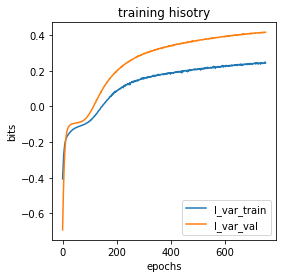

In [20]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

fig.savefig('pngs/DiscreteMonotonic_MP/history.png',dpi=200,bbox_inches='tight')

In [21]:
phi = gpmap.x_to_phi(x_test)

In [22]:
theta = np.squeeze(gpmap.weights[1].numpy())
theta_df = pd.DataFrame(theta,columns=model.alphabet)

In [23]:
#gpmap.weights[1].numpy()

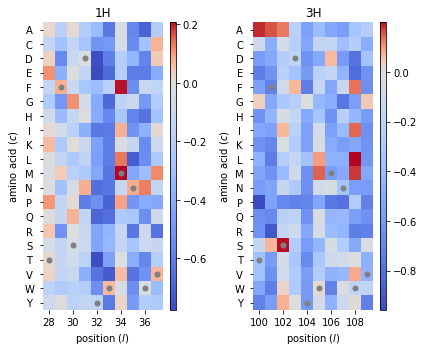

In [24]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=theta_df.loc[0:9].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=theta_df.loc[10:20].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(100,110,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H')

fig.tight_layout()
fig.savefig('pngs/DiscreteMonotonic_MP/GP_map.png',dpi=200,bbox_inches='tight')

In [25]:
#np.save('titeseq_gpmap_discrete_agnostic',logo.df.values.ravel())

In [26]:
# sortseq_gpmap = np.load('sortseq_gpmap_discrete_agnostic.npy')
# titeseq_gpmap = -np.load('titeseq_gpmap_discrete_agnostic.npy')

In [27]:
# plt.figure(figsize=(5,5))
# # Compute R^2 between yhat_test and y_test
# Rsq = np.corrcoef(sortseq_gpmap,titeseq_gpmap)[0, 1]**2

# # Style plot
# xlim = [-1.5, 1.5]

# plt.scatter(sortseq_gpmap,titeseq_gpmap,s=4,color='blue',alpha=0.2)
# plt.xlabel('Sortseq G-P map parameters')
# plt.ylabel('Titeseq G-P map parameters')
# plt.title(f'$R^2$={Rsq:.3}');
# plt.plot(xlim, xlim, '--', color='k', label='diagonal')
# plt.xlim(xlim)
# plt.ylim(xlim)
# plt.show()

/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_38684/2993366307.py:46: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(im)


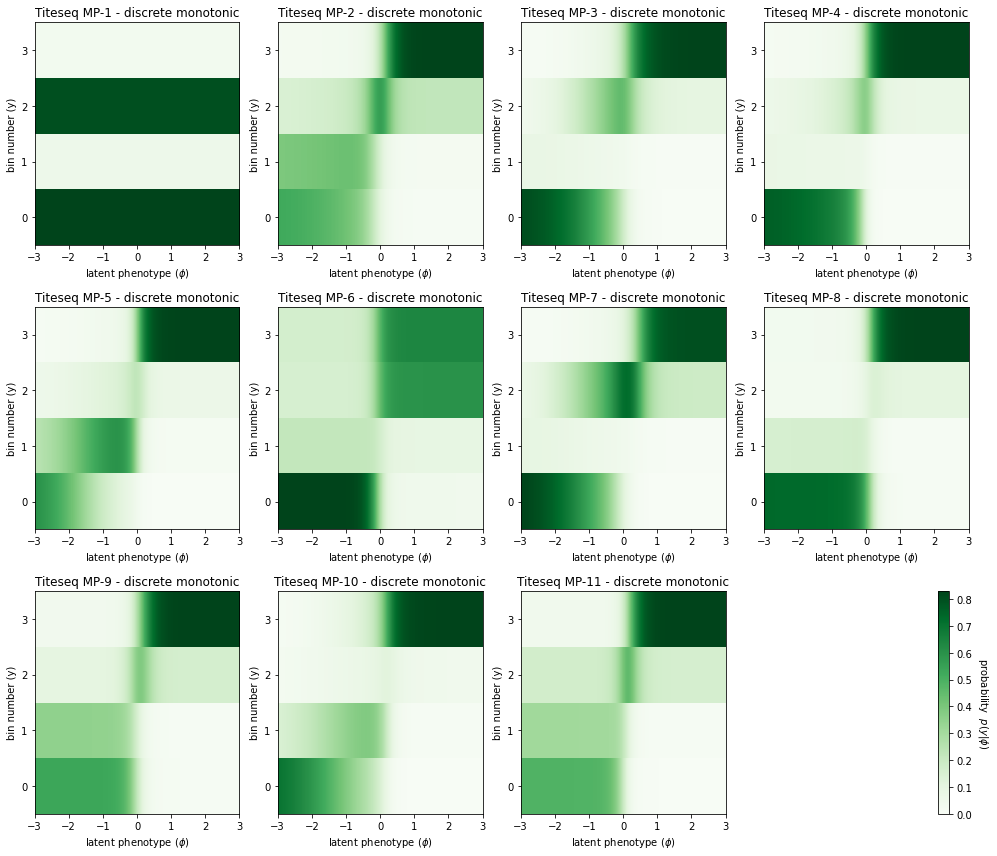

In [28]:
# Create grid in phi space
phi_lim = [-3, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(3,4,figsize=[14,12])

mp_counter = 0
for i in range(3):
    for j in range(4):
        

        if mp_counter==11:
            axs[i,j].axis('off')
            break
        measurement_process = mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete monotonic')
        mp_counter+=1
        
#         if mp_counter ==11:
#             cb = plt.colorbar(im,ax=ax)
#             cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")        
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('pngs/DiscreteMonotonic_MP/MPs.png',dpi=200,bbox_inches='tight')


/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_38684/4163575850.py:48: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(im)


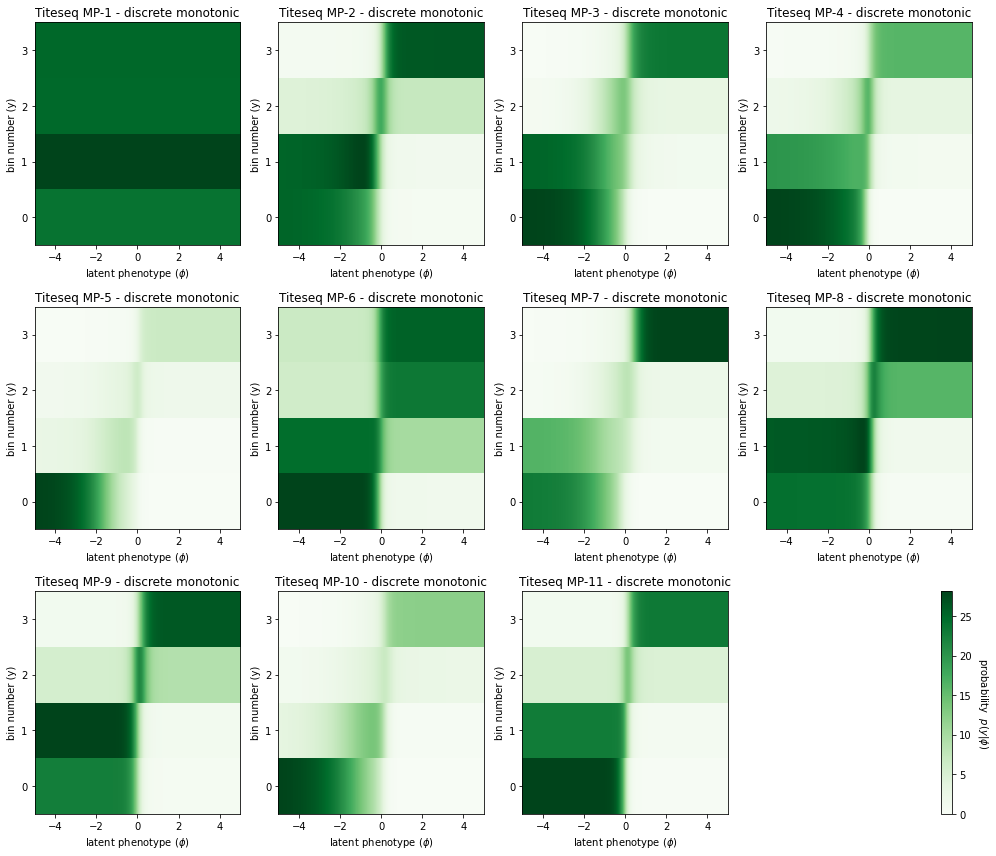

In [29]:
# Create grid in phi space
phi_lim = [-5, 5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(3,4,figsize=[14,12])

mp_counter = 0
for i in range(3):
    for j in range(4):
        

        if mp_counter==11:
            axs[i,j].axis('off')
            break
        measurement_process = mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        
        p_y_mp = N_y[4*mp_counter:4*mp_counter+4]/np.sum(N_y)
        
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]
        im = ax.imshow(measurement_process/p_y_mp.values.reshape(4,1),
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete monotonic')
        mp_counter+=1
        
#         if mp_counter ==11:
#             cb = plt.colorbar(im,ax=ax)
#             cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")        
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('pngs/DiscreteMonotonic_MP/MPs_norm.png',dpi=200,bbox_inches='tight')


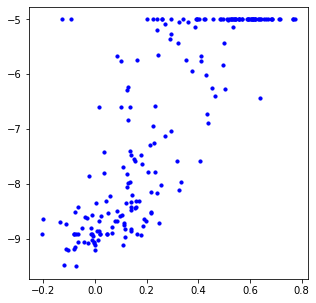

In [30]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
ax = axs
ax.scatter(-theta_df.loc[0:9].values,np.load('CDR1H.raw.heatmap.npy'),color='blue',s=10)


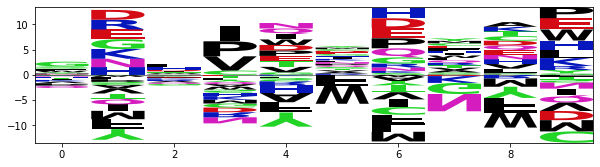

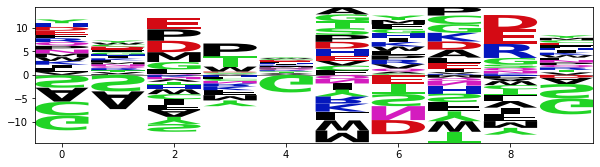

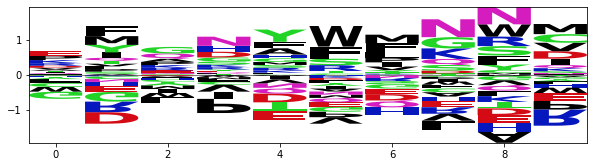

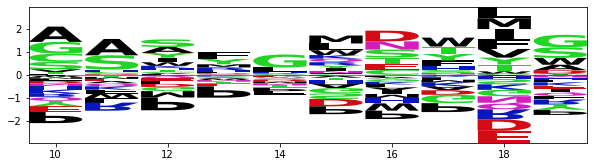

In [31]:
CDR1H_titeseq_df = pd.DataFrame(np.load('CDR1H.raw.heatmap.npy'),columns=model.alphabet)
CDR1H_titeseq_logo = logomaker.Logo(CDR1H_titeseq_df,center_values=True)

CDR3H_titeseq_df = pd.DataFrame(np.load('CDR3H.raw.heatmap.npy'),columns=model.alphabet)
CDR3H_titeseq_logo = logomaker.Logo(CDR3H_titeseq_df,center_values=True)

mavenn2_CDR1H_logo = logomaker.Logo(theta_df.loc[0:9],center_values=True)

mavenn2_CDR3H_logo = logomaker.Logo(theta_df.loc[10:20],center_values=True)

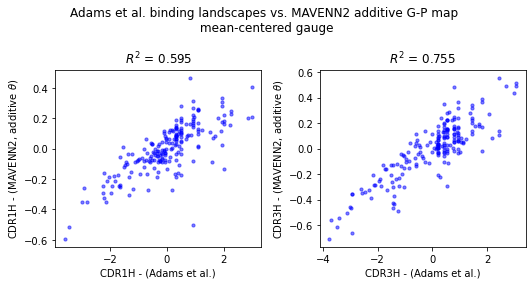

In [32]:
fig, axs = plt.subplots(1,2,figsize=(7.5,4))
ax = axs[0]

Rsq = np.corrcoef(CDR1H_titeseq_logo.df.values.ravel(),-mavenn2_CDR1H_logo.df.values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(CDR1H_titeseq_logo.df.values.ravel(),-mavenn2_CDR1H_logo.df.values.ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR1H - (Adams et al.)')
ax.set_ylabel('CDR1H - (MAVENN2, additive $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(CDR3H_titeseq_logo.df.values.ravel(),-mavenn2_CDR3H_logo.df.values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(CDR3H_titeseq_logo.df.values.ravel(),
           -mavenn2_CDR3H_logo.df.values.ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR3H - (Adams et al.)')
ax.set_ylabel('CDR3H - (MAVENN2, additive $\\theta$)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n mean-centered gauge ')
fig.tight_layout()
fig.savefig('pngs/DiscreteMonotonic_MP/Adams_vs_mavenn_GP_map.png',dpi=200,bbox_inches='tight')


In [33]:
# # Manual Gauge fixing
#from mavenn.src.utils import _x_to_mat

def _x_to_mat1(x, alphabet):
    return (np.array(list(x))[:, np.newaxis] ==
            np.array(alphabet)[np.newaxis, :]).astype(float)

def manual_WT_gauge(theta_lc,L,WT_seq,theta_0=0,model=model):

    C = model.C
    p_lc = _x_to_mat1(WT_seq, list(model.alphabet))

    theta_lclc = np.full(shape=(L, C, L, C), fill_value=np.nan)
    nan_mask_lclc = np.isnan(theta_lclc)
    theta_lclc[nan_mask_lclc] = 0
    _ = np.newaxis

    # Fix 0th order parameter
    fixed_theta_0 = theta_0 \
        + np.sum(p_lc * theta_lc) \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :])

    # Fix 1st order parameters
    fixed_theta_lc = theta_lc \
        - np.sum(theta_lc * p_lc, axis=1)[:, _] \
        + np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=(2, 3)) \
        - np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 2, 3))[:, _]

    # Fix 2nd order parameters
    fixed_theta_lclc = theta_lclc \
        - np.sum(theta_lclc * p_lc[:, :, _, _],
                 axis=1)[:, _, :, :] \
        - np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=3)[:, :, :, _] \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 3))[:, _, :, _]  
    
    return fixed_theta_lc
# np.save('theta_lc_AIE_gf',fixed_theta_lc)

In [34]:
CDR1H_titeseq_WT_gauge = manual_WT_gauge(CDR1H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][0:10],L=10)
CDR3H_titeseq_WT_gauge = manual_WT_gauge(CDR3H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][10:20],L=10)


In [35]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

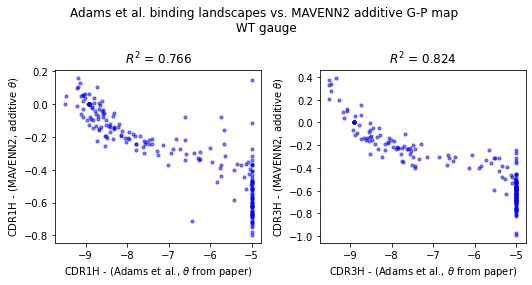

In [36]:
theta_lc_consensus_df.loc[0:9]
fig, axs = plt.subplots(1,2,figsize=(7.5,4))
ax = axs[0]

Rsq = np.corrcoef(-CDR1H_titeseq_df.values.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(CDR1H_titeseq_df.values.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR1H - (Adams et al., $\\theta$ from paper)')
ax.set_ylabel('CDR1H - (MAVENN2, additive $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(CDR3H_titeseq_df.values.ravel(),-theta_lc_consensus_df.loc[10:20].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(CDR3H_titeseq_df.values.ravel(),theta_lc_consensus_df.loc[10:20].values.ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR3H - (Adams et al., $\\theta$ from paper)')
ax.set_ylabel('CDR3H - (MAVENN2, additive $\\theta$)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n WT gauge ')
fig.tight_layout()
fig.savefig('pngs/DiscreteMonotonic_MP/Adams_vs_mavenn_GP_map_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


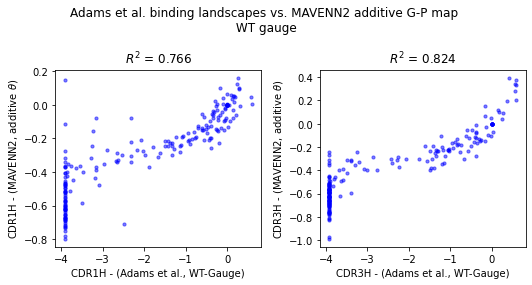

In [37]:
theta_lc_consensus_df.loc[0:9]
fig, axs = plt.subplots(1,2,figsize=(7.5,4))
ax = axs[0]

Rsq = np.corrcoef(CDR1H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(-CDR1H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR1H - (Adams et al., WT-Gauge)')
ax.set_ylabel('CDR1H - (MAVENN2, additive $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(CDR3H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[10:20].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(-CDR3H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[10:20].values.ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR3H - (Adams et al., WT-Gauge)')
ax.set_ylabel('CDR3H - (MAVENN2, additive $\\theta$)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n WT gauge ')
fig.tight_layout()
fig.savefig('pngs/DiscreteMonotonic_MP/Adams_vs_mavenn_GP_map_WT_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


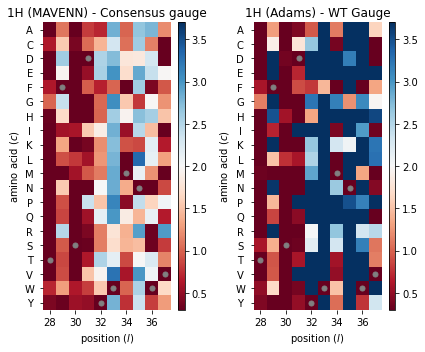

In [38]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=-theta_lc_consensus_df.loc[0:9].values/np.std(theta_lc_consensus_df.loc[0:9].values),
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'][0:10],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='RdBu',
                                cbar=True,
                                clim=[0.3,3.7],
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H (MAVENN) - Consensus gauge')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=CDR1H_titeseq_WT_gauge,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'][0:10],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='RdBu',
                                cbar=True,
                                clim=[0.3,3.7],
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H (Adams) - WT Gauge')

fig.tight_layout()
#fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n mean-centered gauge ')
fig.savefig('pngs/DiscreteMonotonic_MP/GP_map_consensus_gauge.png',dpi=200,bbox_inches='tight')

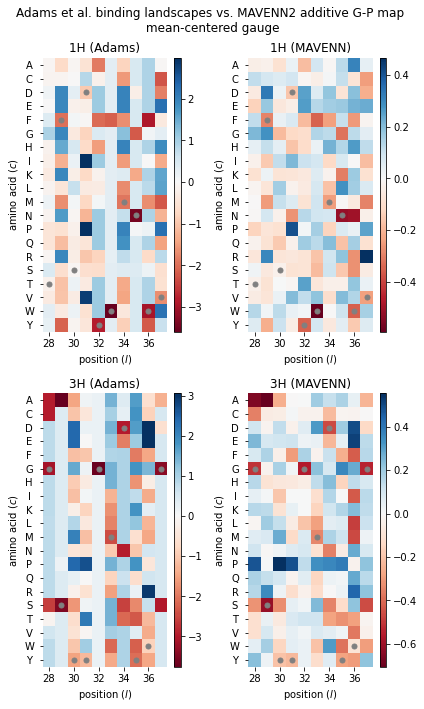

In [39]:
fig, axs = plt.subplots(2,2, figsize=(6,10))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0,0],
                                values=CDR1H_titeseq_logo.df.values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'][0:10],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='RdBu',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H (Adams)')


heatmap_ax, cb = mavenn.heatmap(ax=axs[0,1],
                                values=-mavenn2_CDR1H_logo.df.values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'][0:10],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='RdBu',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H (MAVENN)')


# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[1,0],
                                values=CDR3H_titeseq_logo.df.values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'][10:20],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='RdBu',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H (Adams)')


heatmap_ax, cb = mavenn.heatmap(ax=axs[1,1],
                                values=-mavenn2_CDR3H_logo.df.values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'][10:20],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='RdBu',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H (MAVENN)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n mean-centered gauge ')
fig.tight_layout()
fig.savefig('pngs/DiscreteMonotonic_MP/landscape_comparisons.png',dpi=200,bbox_inches='tight')

In [44]:
# np.save('models/theta_0_DM.npy',model.model.get_weights()[0])
# np.save('models/theta_lc_DM.npy',model.model.get_weights()[1])
#np.save('models/theta_lc_consensus_DM_df.npy', theta_lc_consensus_df.values)
